# Exploratory Data Analysis (EDA) - Centrifugal pump

- Obejtivo:
    -  Estabelecer uma compreensão inicial das características do banco obtido, assim como do comportamento dinâmico das variáveis monitoradas. 
    - Realizar algumas limpezas iniciais de acordo com as inferências feitas a partir da análise dos dados.


- Pré-requisitos:
    - A data e o horário de cada instância devem ser registrados em uma coluna denominada de timestamp.


- Análises:
    - Matriz de correlação
    - Histogramas
    - Boxplots e gráficos de violino
    - Estatísticas descritas
    - Gráficos de linha

## Bibliotecas

In [1]:
import datetime
import math
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
# Caminho no qual as imagens geradas serão salvas quando exportadas
saving_path = r"C:\Users\anaso\Desktop\workspace\doutorado\imagens"

## Funções

In [3]:
def print_overview(data):
    
    """
    Retorna algumas informações gerais sobre o banco de dados, como existência de nulos e duplicatas, dentre outros.
    """
    
    # Shape do banco
    print("Shape do banco: ", data.shape)
    
    # Alguma linha com todos os valores zerados?
    zero_rows = data.index[(data==0).all(axis=1)].tolist()
    print("\nQuantidade de linhas zeradas: ", len(zero_rows))
    
    # Existem nulos?
    print("Quantidade de nulos no banco: ", data.isnull().sum().sum())
    
    # Há duplicatas baseado no timestamp?
    qtd_duplis = len(data[data.duplicated(['timestamp'])])
    if (qtd_duplis > 0):
        print("Quantidade de duplicatas: ", qtd_duplis)
#         print(data[data.duplicated(['timestamp'])])
    else:
        print("\nNão há registros duplicados.")
    
    print()
    
    # Alguma coluna possui um único valor constante?
    single_values_columns = []
    for col in (data.columns):
        unique_values = data[col].nunique()
        if (unique_values == 1):
            single_values_columns.append(col)
    if len(single_values_columns) > 0:
        print("Existem " + str(len(single_values_columns)) + " colunas constantes. São elas: " + str(single_values_columns))
    else:
        print("Não há colunas constantes.")
    
    # Alguma linha inteiramente zerada?
    data_sem_dt = data.drop(['timestamp'], 1)
    zero_rows = data_sem_dt.index[(data_sem_dt == 0).all(axis=1)].tolist()
    if len(zero_rows) > 0:
        print("Existem " + str(len(zero_rows)) + " linhas inteiramente zeradas.")
    else:
        print("Não há linhas inteiramente zeradas.")
    
    # Alguma linha com todas as colunas NaN?
    nan_rows = data.index[(data == float('nan')).all(axis=1)].tolist()
    if len(nan_rows) > 0:
        print("Existem " + str(len(nan_rows)) + " instâncias sem registro.")
    else:
        print("Não há linhas inteiramente sem registro (nan).")

In [4]:
def plot_comparison(x, title):
    
    """
    Constroi o histograma, o gráfico de caixas (boxplot) e o gráfico de violino para a variável definida.
    """
    
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8,5), dpi=100)
    
    sns.distplot(x, ax=ax[0])
    ax[0].set_title('Histograma', fontsize=14)
    ax[0].set(ylabel='Densidade')
    
    sns.boxplot(x, ax=ax[1])
    ax[1].set_title('Boxplot', fontsize=14)
    ax[1].set(xlabel=None)
    
    sns.violinplot(x, ax=ax[2])
    ax[2].set_title('Gráfico de violino', fontsize=14)
    
    fig.suptitle(title, fontsize=12)
    fig.tight_layout()
    
#     fig.savefig(saving_path + '/hist_box_viol.png', format='png')
    
    plt.show()

## Dados brutos

In [5]:
data = pd.read_csv(r"D:\Caso 2 - Bomba Centrífuga\data_bomba_norm.csv", sep=';')

# Adequações iniciais
data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
data.rename(columns={'Time': 'timestamp'}, inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [6]:
data.head()

PDIT-301  PIT-302  PIT-303  PIT-304   PIT-305   PIT-306    VT-301  \
0  -0.74663      NaN      NaN      NaN -0.691068 -0.867744  0.058151   
1  -0.74663      NaN      NaN      NaN -0.683510 -0.867451  0.058151   
2  -0.74663      NaN      NaN      NaN -0.691824 -0.867333  0.058151   
3  -0.74663      NaN      NaN      NaN -0.710720 -0.867744  0.058151   
4  -0.74663      NaN      NaN      NaN -0.692580 -0.867451  0.058151   

     VT-302    VT-303    VT-304  ...    TI-309    TI-310  Corrente  Potencia  \
0  0.073512 -0.191947 -0.132590  ... -0.883025 -0.930166 -0.718851       NaN   
1  0.072651 -0.194078 -0.132590  ... -0.883025 -0.930166 -0.718851       NaN   
2  0.072282 -0.194991 -0.133982  ... -0.883025 -0.930166 -0.718851       NaN   
3  0.072282 -0.194991 -0.133187  ... -0.883025 -0.930166 -0.718851       NaN   
4  0.073143 -0.194991 -0.133982  ... -0.883025 -0.930166 -0.718851       NaN   

    FIT-323           timestamp  Run  MA(Run)  Criticidade  HORIMETRO  
0 -0.864166 2011-01-01 00:00:00  0.0      NaN          0.0     3091.0  
1 -0.864166 2011-01-01 00:01:00  0.0      NaN          0.0     3091.0  
2 -0.864551 2011-01-01 00:02:00  0.0      0.0          0.0     3091.0  
3 -0.864551 2011-01-01 00:03:00  0.0      0.0          0.0     3091.0  
4 -0.864166 2011-01-01 00:04:00  0.0      0.0          0.0     3091.0  

[5 rows x 30 columns]

In [7]:
fault_log = pd.read_excel(r"D:\Caso 2 - Bomba Centrífuga\Falhas_Bomba_D.xlsx")

# Adequações iniciais
fault_log.rename(columns={'Unnamed: 8': 'Texto curto'}, inplace=True)
fault_log['InícioAvar'] = pd.to_datetime(fault_log['InícioAvar'])
fault_log['Dt.real fim'] = pd.to_datetime(fault_log['Dt.real fim'])

In [8]:
print("Min. timestamp: ", data.timestamp.min())
print("Max. timestamp: ", data.timestamp.max())

Min. timestamp:  2011-01-01 00:00:00
Max. timestamp:  2018-12-31 23:59:00


In [9]:
# Tamanho do banco

data.shape

(4202704, 30)

In [10]:
# Colunas presentes no banco

data.columns

Index(['PDIT-301', 'PIT-302', 'PIT-303', 'PIT-304', 'PIT-305', 'PIT-306',
       'VT-301', 'VT-302', 'VT-303', 'VT-304', 'VT-321', 'VT-322', 'VT-323',
       'VT-324', 'ZT-301', 'ZT-302', 'TI-305', 'TI-306', 'TI-307', 'TI-308',
       'TI-309', 'TI-310', 'Corrente', 'Potencia', 'FIT-323', 'timestamp',
       'Run', 'MA(Run)', 'Criticidade', 'HORIMETRO'],
      dtype='object')

In [11]:
# Informações gerais sobre o banco

print_overview(data)

Shape do banco:  (4202704, 30)

Quantidade de linhas zeradas:  0
Quantidade de nulos no banco:  937855
Quantidade de duplicatas:  480

Não há colunas constantes.
Não há linhas inteiramente zeradas.
Não há linhas inteiramente sem registro (nan).


In [12]:
# Distribuição de registros nulos

print("Total: ", data.isnull().sum().sum())
data.isnull().sum()

Total:  937855


PDIT-301         1740
PIT-302        216799
PIT-303        216845
PIT-304        216979
PIT-305           199
PIT-306           324
VT-301           1330
VT-302           1337
VT-303           1315
VT-304           1288
VT-321          69383
VT-322          13671
VT-323           1249
VT-324           1333
ZT-301           1686
ZT-302           1819
TI-305           1441
TI-306           1530
TI-307           1915
TI-308           1835
TI-309           1620
TI-310           1751
Corrente          568
Potencia       174982
FIT-323          1510
timestamp           0
Run               568
MA(Run)           623
Criticidade         0
HORIMETRO        2215
dtype: int64

In [13]:
# Investigação do caráter dos dados - busca por booleanos

for col in data.columns:
    
    qtd_values = data[col].nunique()
    if (qtd_values <= 2):
        print(col)
        print(data[col].unique())
        print()

Run
[ 0.  1. nan]

Criticidade
[0. 1.]



## Corrigindo os dados

In [14]:
# Remove todas as instâncias nas quais a bomba esteve desligada

data_pump_on = data[data['Run'] == 1].copy()
data_pump_on.shape

(1435340, 30)

In [15]:
# Informações gerais sobre o banco filtrado

print_overview(data_pump_on)

Shape do banco:  (1435340, 30)

Quantidade de linhas zeradas:  0
Quantidade de nulos no banco:  174629
Quantidade de duplicatas:  14

Existem 1 colunas constantes. São elas: ['Run']
Não há linhas inteiramente zeradas.
Não há linhas inteiramente sem registro (nan).


In [16]:
# Distribuição de registros nulos

print("Total: ", data_pump_on.isnull().sum().sum())
data_pump_on.isnull().sum()

Total:  174629


PDIT-301        1044
PIT-302        33330
PIT-303        33335
PIT-304        33439
PIT-305           60
PIT-306           67
VT-301           846
VT-302           846
VT-303           845
VT-304           845
VT-321          5199
VT-322           845
VT-323           845
VT-324           845
ZT-301           935
ZT-302           932
TI-305           983
TI-306          1022
TI-307           955
TI-308           954
TI-309           936
TI-310           948
Corrente           0
Potencia       51938
FIT-323          956
timestamp          0
Run                0
MA(Run)           28
Criticidade        0
HORIMETRO       1651
dtype: int64

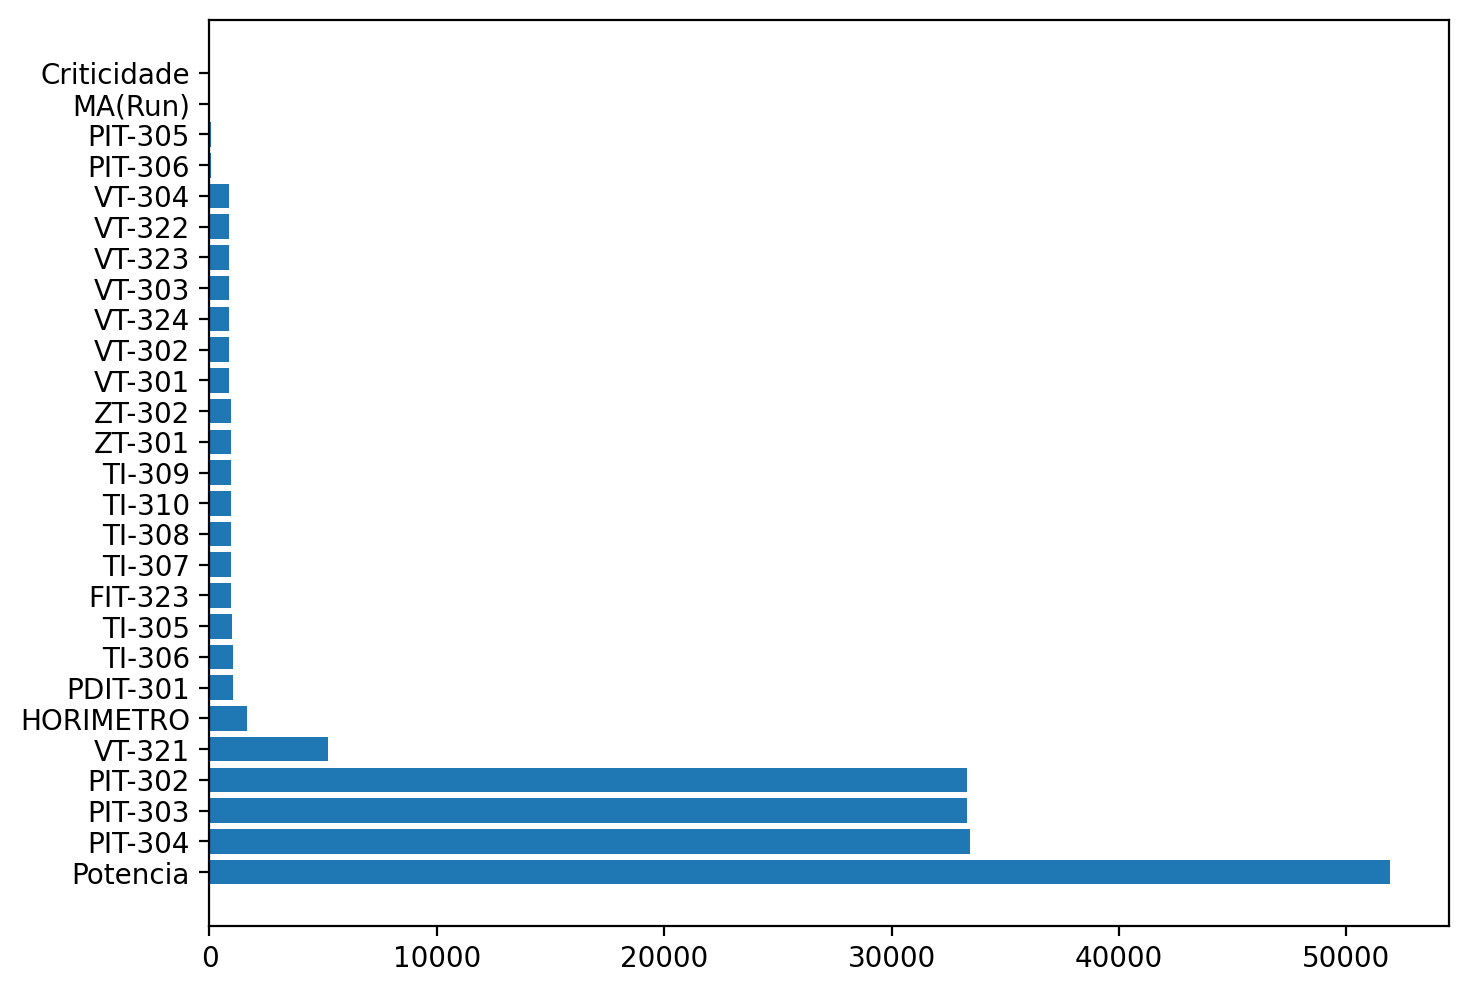

In [17]:
# Gráfico da distribuição de registros nulos

data_pump_on_nan_number = pd.DataFrame(data_pump_on.isnull().sum(), \
                                       columns=['nan_number']).sort_values('nan_number', ascending=False)

data_pump_on_nan_number.drop(data_pump_on_nan_number.index[[26,27,28]], inplace=True)

variables = data_pump_on_nan_number.reset_index()['index'].values.tolist()

plt.figure(figsize=(8,6), dpi=200)
plt.barh(variables, data_pump_on_nan_number['nan_number'])

# for rectangle in plot:
#     width = rectangle.get_width()
#     plt.text(width, rectangle.get_y(), int(width),  va = 'bottom') #ha='center',

plt.savefig(saving_path + "/nan_por_var_pump_on.png", bbox_inches='tight');
plt.show()

In [18]:
# Um ano tem 525.600 minutos

data_pump_on['year'] = data_pump_on.timestamp.dt.year
counting_df = pd.DataFrame(index=data_pump_on.year.unique(), columns=data_pump_on.columns)

for year in data_pump_on.year.unique():
    
    data_year = data_pump_on[data_pump_on['year'] == year].copy()
    
    for col in data_pump_on.columns:
        
        data_year_col = data_year[col].copy()
        counting_df.loc[year,col] = len(data_year_col)
        
counting_df.drop(['year','MA(Run)','Criticidade','HORIMETRO'], axis=1, inplace=True)

data_per_year = {}
keys = counting_df.index
values = counting_df.iloc[:,0].values

i=0
for key in keys:
    data_per_year[key] = values[i]
    i=i+1

# Remove a coluna auxiliar criada
data_pump_on.drop(['year'], axis=1, inplace=True)

data_per_year

{2011: 147763,
 2012: 440137,
 2013: 224338,
 2014: 335290,
 2015: 157351,
 2016: 69713,
 2017: 48665,
 2018: 12083}

In [19]:
# Todos os valores NaN do banco são preenchidos com os valores anteriores ou posteriores disponíveis

data_pump_on_sem_nan = data_pump_on.fillna(method='ffill').fillna(method='bfill')

In [20]:
# Remove colunas que não fazem sentido para a fase de modelagem

data_pump_on_sem_nan.drop(['Run','Criticidade','HORIMETRO','MA(Run)'], axis=1, inplace=True)

In [21]:
# Informações gerais sobre o banco filtrado e com NaN corrigidos

print_overview(data_pump_on_sem_nan)

Shape do banco:  (1435340, 26)

Quantidade de linhas zeradas:  0
Quantidade de nulos no banco:  0
Quantidade de duplicatas:  14

Não há colunas constantes.
Não há linhas inteiramente zeradas.
Não há linhas inteiramente sem registro (nan).


In [22]:
# Busca por colunas duplicadas tomando-se como referência o timestamp de registro

data_pump_on_sem_nan[data_pump_on_sem_nan.duplicated('timestamp')]

PDIT-301   PIT-302   PIT-303   PIT-304   PIT-305   PIT-306    VT-301  \
414185  2.920049  0.557837  0.346852  0.439124  0.624053  1.137026  0.526486   
414186  2.931570  0.557837  0.346852  0.439124  0.610448  1.137554  0.524855   
414187  2.969015  0.557837  0.346852  0.439124  0.576436  1.137378  0.519659   
414188  2.969015  0.557837  0.346852  0.439124  0.601378  1.136849  0.519354   
414189  2.969015  0.557837  0.346852  0.435936  0.612716  1.136320  0.519741   
414190  2.969015  0.557837  0.346852  0.433954  0.608181  1.135439  0.520576   
414191  2.969015  0.557837  0.346852  0.433954  0.614983  1.137378  0.526017   
414192  2.969015  0.557055  0.346852  0.433954  0.603646  1.136320  0.529807   
414193  2.969015  0.556568  0.346852  0.433954  0.576436  1.135645  0.530377   
414194  2.969015  0.556568  0.346852  0.433954  0.594576  1.137643  0.529725   
414195  2.969015  0.556568  0.346852  0.433954  0.587774  1.134528  0.528340   
414196  2.969015  0.556568  0.343813  0.433954  0.580971  1.133618  0.528442   
414197  2.969015  0.556568  0.341924  0.433954  0.567367  1.137995  0.523449   
414198  2.969015  0.555786  0.344963  0.433954  0.592309  1.135439  0.523348   

          VT-302    VT-303    VT-304  ...    TI-305    TI-306    TI-307  \
414185  0.479372  0.351243  0.482470  ...  0.494578 -0.470124  0.918876   
414186  0.484272  0.359008  0.482576  ...  0.504929 -0.479227  0.918876   
414187  0.484477  0.367204  0.486075  ...  0.516492 -0.479227  0.918876   
414188  0.478449  0.363068  0.490396  ...  0.525046 -0.479227  0.918876   
414189  0.474616  0.354567  0.492065  ...  0.529421 -0.479227  0.918876   
414190  0.479638  0.360708  0.484643  ...  0.536413 -0.479227  0.918876   
414191  0.483185  0.367102  0.479209  ...  0.540984 -0.479227  0.918876   
414192  0.483370  0.367635  0.488407  ...  0.544968 -0.479227  0.918876   
414193  0.481053  0.364463  0.490979  ...  0.553991 -0.479227  0.918876   
414194  0.475764  0.365326  0.492410  ...  0.560554 -0.479227  0.918876   
414195  0.473242  0.373192  0.487056  ...  0.563405 -0.479227  0.918876   
414196  0.475456  0.364235  0.476452  ...  0.568405 -0.479227  0.918876   
414197  0.480028  0.370020  0.483238  ...  0.575436 -0.479227  0.949800   
414198  0.478449  0.376871  0.483901  ...  0.580475 -0.485180  0.973448   

          TI-308    TI-309    TI-310  Corrente  Potencia   FIT-323  \
414185  0.844855  0.775967  0.756880  1.373433  1.381991  1.129865   
414186  0.876830  0.775967  0.796193  1.385987  1.378711  1.127684   
414187  0.901281  0.775967  0.826954  1.387382  1.379804  1.133099   
414188  0.901281  0.775967  0.826954  1.387382  1.384139  1.132149   
414189  0.901281  0.775967  0.826954  1.387382  1.385271  1.129147   
414190  0.901281  0.775967  0.826954  1.387382  1.379804  1.130379   
414191  0.901281  0.775967  0.826954  1.387382  1.379804  1.133561   
414192  0.901281  0.775967  0.826954  1.387382  1.373244  1.132149   
414193  0.901281  0.775967  0.826954  1.387382  1.385271  1.129814   
414194  0.901281  0.775967  0.826954  1.387382  1.384177  1.133048   
414195  0.901281  0.775967  0.826954  1.387382  1.368984  1.129865   
414196  0.901281  0.775967  0.826954  1.387382  1.386364  1.127171   
414197  0.901281  0.809988  0.826954  1.387382  1.379804  1.131071   
414198  0.901281  0.836004  0.826954  1.374828  1.384177  1.129301   

                 timestamp  
414185 2011-10-16 01:34:00  
414186 2011-10-16 01:35:00  
414187 2011-10-16 01:36:00  
414188 2011-10-16 01:37:00  
414189 2011-10-16 01:38:00  
414190 2011-10-16 01:39:00  
414191 2011-10-16 01:40:00  
414192 2011-10-16 01:41:00  
414193 2011-10-16 01:42:00  
414194 2011-10-16 01:43:00  
414195 2011-10-16 01:44:00  
414196 2011-10-16 01:45:00  
414197 2011-10-16 01:46:00  
414198 2011-10-16 01:47:00  

[14 rows x 26 columns]

In [23]:
# Exemplo de linha duplicada

data_pump_on_sem_nan[data_pump_on_sem_nan['timestamp'] == '2011-10-16 01:34:00']

PDIT-301   PIT-302   PIT-303   PIT-304   PIT-305   PIT-306    VT-301  \
414125  3.092870  0.227461  0.478270  0.571832  0.290738  1.324200  0.333316   
414185  2.920049  0.557837  0.346852  0.439124  0.624053  1.137026  0.526486   

          VT-302    VT-303    VT-304  ...    TI-305    TI-306    TI-307  \
414125  0.326905  0.215262  0.248061  ... -0.743302 -0.873475 -0.373448   
414185  0.479372  0.351243  0.482470  ...  0.494578 -0.470124  0.918876   

          TI-308    TI-309    TI-310  Corrente  Potencia   FIT-323  \
414125 -0.379950 -0.883025 -0.819748  0.775040  0.919514  0.229035   
414185  0.844855  0.775967  0.756880  1.373433  1.381991  1.129865   

                 timestamp  
414125 2011-10-16 01:34:00  
414185 2011-10-16 01:34:00  

[2 rows x 26 columns]

In [24]:
# Remoção de registros duplicados tomando-se como referência o timestamp 

final_data = data_pump_on_sem_nan.drop_duplicates(subset=['timestamp'], keep='last')
final_data = final_data.reset_index().drop(['index'], axis=1)
final_data

PDIT-301   PIT-302   PIT-303   PIT-304   PIT-305   PIT-306    VT-301  \
0        2.032903  0.581649  0.425867  0.516853  0.518994  1.329018  0.604650   
1        2.191322  0.581649  0.425867  0.516853  1.082078  1.336500  0.604650   
2        2.120753  0.581649  0.425867  0.516853  1.142543  1.337107  0.615776   
3        2.034343  0.581649  0.425867  0.516853  1.038996  1.336157  0.621400   
4        1.947933  0.581649  0.425867  0.516853  1.082834  1.337508  0.636743   
...           ...       ...       ...       ...       ...       ...       ...   
1435321  2.191322  0.502052  0.405990  0.371909  0.801670  1.442744  1.007596   
1435322  2.163959  0.501354  0.405990  0.369410  0.796379  1.441395  1.004132   
1435323  2.104911  0.502010  0.405990  0.366738  0.780356  1.441217  0.993231   
1435324  2.104911  0.502010  0.405990  0.366738  0.794263  1.441217  0.998783   
1435325  2.104911  0.502010  0.405990  0.364239  0.772344  1.440594  0.990123   

           VT-302    VT-303    VT-304  ...    TI-305    TI-306    TI-307  \
0        0.534263  0.673536  0.647971  ... -0.512816  0.202652  0.130550   
1        0.549301  0.659568  0.658031  ... -0.520726  0.226286  0.374096   
2        0.534694  0.671633  0.648567  ... -0.499632  0.268301  0.461403   
3        0.524638  0.710570  0.654373  ... -0.429320  0.340953  0.517234   
4        0.532172  0.693785  0.642961  ... -0.351977  0.413606  0.570539   
...           ...       ...       ...  ...       ...       ...       ...   
1435321  1.052474  0.890640  0.669780  ...  0.598424  1.657911  1.132756   
1435322  1.049829  0.868374  0.705109  ...  0.644830  1.697185  1.132756   
1435323  1.060023  0.886453  0.686560  ...  0.697935  1.734649  1.132756   
1435324  1.058824  0.904989  0.675168  ...  0.736197  1.757174  1.132756   
1435325  1.048199  0.954564  0.684293  ...  0.777212  1.788219  1.132756   

           TI-308    TI-309    TI-310  Corrente  Potencia   FIT-323  \
0        0.087849 -0.718167 -0.619378  0.941028  0.877531  0.202653   
1        0.350827 -0.568308 -0.428532  0.937541  0.877531  0.186614   
2        0.438111 -0.427374 -0.217478  0.923592  0.877531  0.178273   
3        0.494220 -0.260157 -0.056994  0.913131  0.877531  0.174552   
4        0.550647 -0.120101  0.033708  0.916618  0.877531  0.172243   
...           ...       ...       ...       ...       ...       ...   
1435321  1.245426  1.440666  1.338944  1.275793  1.273751  0.211610   
1435322  1.245426  1.440666  1.337608  1.275793  1.273751  0.210481   
1435323  1.245426  1.440666  1.339330  1.275793  1.273751  0.208915   
1435324  1.245426  1.440666  1.339330  1.285790  1.274626  0.208428   
1435325  1.245426  1.440666  1.339330  1.289742  1.273751  0.206991   

                  timestamp  
0       2011-01-03 10:31:00  
1       2011-01-03 10:32:00  
2       2011-01-03 10:33:00  
3       2011-01-03 10:34:00  
4       2011-01-03 10:35:00  
...                     ...  
1435321 2018-12-24 09:59:00  
1435322 2018-12-24 10:00:00  
1435323 2018-12-24 10:01:00  
1435324 2018-12-24 10:02:00  
1435325 2018-12-24 10:03:00  

[1435326 rows x 26 columns]

## Análises gráficas e indicadores do banco de dados final

In [25]:
# Informações gerais sobre o banco final

print_overview(final_data)

Shape do banco:  (1435326, 26)

Quantidade de linhas zeradas:  0
Quantidade de nulos no banco:  0

Não há registros duplicados.

Não há colunas constantes.
Não há linhas inteiramente zeradas.
Não há linhas inteiramente sem registro (nan).


In [26]:
final_data.columns

Index(['PDIT-301', 'PIT-302', 'PIT-303', 'PIT-304', 'PIT-305', 'PIT-306',
       'VT-301', 'VT-302', 'VT-303', 'VT-304', 'VT-321', 'VT-322', 'VT-323',
       'VT-324', 'ZT-301', 'ZT-302', 'TI-305', 'TI-306', 'TI-307', 'TI-308',
       'TI-309', 'TI-310', 'Corrente', 'Potencia', 'FIT-323', 'timestamp'],
      dtype='object')

In [27]:
# Estatísticas descritivas gerais do banco de dados

final_data.describe()[1:].T

mean       std        min       25%       50%       75%  \
PDIT-301  1.024229  0.570077  -0.746630  0.722346  0.808756  1.139996   
PIT-302   0.452206  0.472352 -13.029813  0.488053  0.517235  0.554496   
PIT-303   0.303766  0.067589  -0.333236  0.294449  0.312355  0.327139   
PIT-304   0.372506  0.365139 -41.632613  0.377079  0.397761  0.408102   
PIT-305   0.981099  0.327281  -1.598049  0.829937  1.025392  1.165822   
PIT-306   1.112194  0.220356  -0.877968  1.137460  1.153313  1.161457   
VT-301    0.519650  0.068376  -1.597702  0.501168  0.526241  0.549812   
VT-302    0.484073  0.057385  -1.627623  0.475436  0.485256  0.499683   
VT-303    0.671722  0.194957  -2.179213  0.596309  0.687943  0.760926   
VT-304    0.642667  0.177265  -2.257168  0.549654  0.627056  0.722981   
VT-321    0.833738  0.639295  -8.521860  0.700465  0.852623  1.015520   
VT-322    0.814594  0.329122  -7.848847  0.734163  0.809744  0.880064   
VT-323    0.934611  0.233552  -0.912458  0.866988  0.932039  1.015530   
VT-324    1.215094  0.287560  -1.009348  1.106257  1.222155  1.370141   
ZT-301   -0.081414  0.161672  -1.290600 -0.162188 -0.095361 -0.028534   
ZT-302   -0.195696  0.255803  -1.370387 -0.342906 -0.214470 -0.160956   
TI-305    1.204224  0.248988  -3.816009  1.055725  1.239415  1.419882   
TI-306    0.844132  0.733990  -9.414561  0.277230  0.858271  1.446491   
TI-307    1.131309  0.226609  -2.344456  1.084799  1.138820  1.195046   
TI-308    1.103603  0.240208  -2.286526  1.069443  1.125869  1.182295   
TI-309    1.048074  0.236923  -2.485655  1.022243  1.083199  1.142930   
TI-310    1.069743  0.241802  -2.689394  1.036403  1.107390  1.178378   
Corrente  1.385083  0.116014   0.537682  1.345536  1.359485  1.452475   
Potencia  1.350960  0.259044  -0.720472  1.339351  1.354439  1.424630   
FIT-323   1.091267  0.290691  -0.866091  1.040269  1.071097  1.151422   

                max  
PDIT-301  43.495465  
PIT-302    1.344497  
PIT-303    0.768293  
PIT-304    0.881281  
PIT-305    3.635832  
PIT-306    1.510982  
VT-301     1.461917  
VT-302     2.331089  
VT-303     2.243489  
VT-304     2.320088  
VT-321     9.697208  
VT-322     8.428892  
VT-323     2.378325  
VT-324     3.467813  
ZT-301     3.246003  
ZT-302     3.091664  
TI-305     2.937329  
TI-306     3.190141  
TI-307     1.470500  
TI-308     1.463868  
TI-309     1.513569  
TI-310     1.601492  
Corrente  11.180668  
Potencia   2.255120  
FIT-323    2.604602

In [28]:
# Informações sobre os tipos dos dados presentes no banco

final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1435326 entries, 0 to 1435325
Data columns (total 26 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   PDIT-301   1435326 non-null  float64       
 1   PIT-302    1435326 non-null  float64       
 2   PIT-303    1435326 non-null  float64       
 3   PIT-304    1435326 non-null  float64       
 4   PIT-305    1435326 non-null  float64       
 5   PIT-306    1435326 non-null  float64       
 6   VT-301     1435326 non-null  float64       
 7   VT-302     1435326 non-null  float64       
 8   VT-303     1435326 non-null  float64       
 9   VT-304     1435326 non-null  float64       
 10  VT-321     1435326 non-null  float64       
 11  VT-322     1435326 non-null  float64       
 12  VT-323     1435326 non-null  float64       
 13  VT-324     1435326 non-null  float64       
 14  ZT-301     1435326 non-null  float64       
 15  ZT-302     1435326 non-null  float64       
 16  

In [29]:
# Skewness e kurtosis para o banco completo

sk_kr = pd.DataFrame(final_data.kurt(), columns=['kurtosis'])
sk_kr['skewness'] = final_data.skew()
sk_kr

kurtosis    skewness
PDIT-301     56.964216    3.408163
PIT-302     569.557600  -20.774107
PIT-303      60.651543   -6.695281
PIT-304   11955.762115 -104.113491
PIT-305       5.561213   -1.492765
PIT-306      69.649835   -8.096344
VT-301       27.820435   -2.789408
VT-302       45.698277   -2.367845
VT-303        6.724229   -0.195615
VT-304       14.164199    1.269835
VT-321      147.311495   -8.346690
VT-322       69.493084    3.789346
VT-323       36.018762   -4.501318
VT-324       31.211465   -4.308938
ZT-301       85.834933    6.143374
ZT-302       16.207659    2.831291
TI-305        5.953250   -0.334748
TI-306       -0.648979   -0.148343
TI-307       58.880657   -6.984176
TI-308       78.891374   -7.748896
TI-309       43.274571   -5.629670
TI-310       41.178245   -5.359797
Corrente    508.193317    7.833436
Potencia     44.722855   -6.002664
FIT-323      20.841001   -3.276005

In [30]:
# Matriz de correlação

data_corr = final_data.drop(['timestamp'], axis=1).corr()
data_corr

PDIT-301   PIT-302   PIT-303   PIT-304   PIT-305   PIT-306  \
PDIT-301  1.000000 -0.000470 -0.031446  0.025199 -0.210479 -0.189897   
PIT-302  -0.000470  1.000000  0.175359  0.003769  0.030897  0.129793   
PIT-303  -0.031446  0.175359  1.000000  0.048554  0.340268  0.677752   
PIT-304   0.025199  0.003769  0.048554  1.000000  0.013632  0.010088   
PIT-305  -0.210479  0.030897  0.340268  0.013632  1.000000  0.518891   
PIT-306  -0.189897  0.129793  0.677752  0.010088  0.518891  1.000000   
VT-301   -0.058376  0.093770  0.616773 -0.010282  0.374664  0.699190   
VT-302   -0.070569  0.120255  0.600106 -0.006904  0.419721  0.766452   
VT-303   -0.375429  0.079526  0.168348 -0.020625  0.368826  0.535644   
VT-304   -0.218807  0.056167  0.181411  0.000105  0.323671  0.494050   
VT-321   -0.104526  0.050892  0.161163 -0.001562  0.150527  0.250755   
VT-322    0.003108  0.123244  0.418865  0.003811  0.282644  0.539251   
VT-323    0.055042  0.139640  0.709110  0.033729  0.362560  0.767108   
VT-324   -0.002178  0.186603  0.646840  0.021509  0.312707  0.739861   
ZT-301    0.113680  0.043037  0.102018  0.003150 -0.049157  0.122791   
ZT-302    0.159956  0.082924  0.081292  0.021573 -0.068855 -0.079773   
TI-305   -0.345016  0.027874 -0.194819 -0.088178  0.059073  0.005173   
TI-306   -0.227645  0.001741 -0.214713 -0.006638  0.049626  0.020531   
TI-307   -0.218820  0.115125  0.517709 -0.001899  0.493811  0.835809   
TI-308   -0.205952  0.113504  0.498898 -0.000579  0.482222  0.802860   
TI-309   -0.235687  0.120274  0.437983 -0.008774  0.483055  0.772755   
TI-310   -0.238115  0.136942  0.443713 -0.010127  0.472857  0.769858   
Corrente  0.180680  0.049901 -0.184139 -0.000021 -0.107434 -0.379867   
Potencia  0.114414  0.013620 -0.089800 -0.007141 -0.073314 -0.155737   
FIT-323   0.005917  0.150969  0.499375  0.020349  0.338533  0.501032   

            VT-301    VT-302    VT-303    VT-304  ...    ZT-302    TI-305  \
PDIT-301 -0.058376 -0.070569 -0.375429 -0.218807  ...  0.159956 -0.345016   
PIT-302   0.093770  0.120255  0.079526  0.056167  ...  0.082924  0.027874   
PIT-303   0.616773  0.600106  0.168348  0.181411  ...  0.081292 -0.194819   
PIT-304  -0.010282 -0.006904 -0.020625  0.000105  ...  0.021573 -0.088178   
PIT-305   0.374664  0.419721  0.368826  0.323671  ... -0.068855  0.059073   
PIT-306   0.699190  0.766452  0.535644  0.494050  ... -0.079773  0.005173   
VT-301    1.000000  0.888800  0.179033  0.124454  ...  0.044888  0.111596   
VT-302    0.888800  1.000000  0.311578  0.294649  ...  0.056914  0.132940   
VT-303    0.179033  0.311578  1.000000  0.789125  ... -0.100723  0.303268   
VT-304    0.124454  0.294649  0.789125  1.000000  ... -0.134352  0.190632   
VT-321    0.289402  0.278152  0.272201  0.205216  ... -0.041103  0.026318   
VT-322    0.542065  0.566794  0.303008  0.227430  ...  0.011517  0.019032   
VT-323    0.698454  0.740487  0.188757  0.201218  ... -0.012095 -0.147434   
VT-324    0.540615  0.507473  0.184547  0.175781  ... -0.037976 -0.088198   
ZT-301    0.063878  0.110694  0.033182 -0.112040  ...  0.710035 -0.105437   
ZT-302    0.044888  0.056914 -0.100723 -0.134352  ...  1.000000 -0.218385   
TI-305    0.111596  0.132940  0.303268  0.190632  ... -0.218385  1.000000   
TI-306    0.034952  0.029653  0.263360  0.210455  ... -0.031110  0.567915   
TI-307    0.604232  0.657321  0.546363  0.536682  ... -0.158002  0.248896   
TI-308    0.576061  0.639166  0.544964  0.541223  ... -0.154192  0.256119   
TI-309    0.543770  0.655010  0.600863  0.566867  ... -0.138468  0.332065   
TI-310    0.518560  0.626881  0.606254  0.538324  ... -0.077010  0.339058   
Corrente -0.315035 -0.197795 -0.167412 -0.125447  ...  0.138086  0.037924   
Potencia -0.235703 -0.092294 -0.017032 -0.005375  ...  0.041363  0.027794   
FIT-323   0.394335  0.458342  0.198962  0.246598  ...  0.025812 -0.028576   

            TI-306    TI-307    TI-308    TI-309    TI-310  Corrente  \
PDIT-301 -0.227645 -0.218820 -0.205952 -0.235687 -0.238115  0.

### Análises gráficas

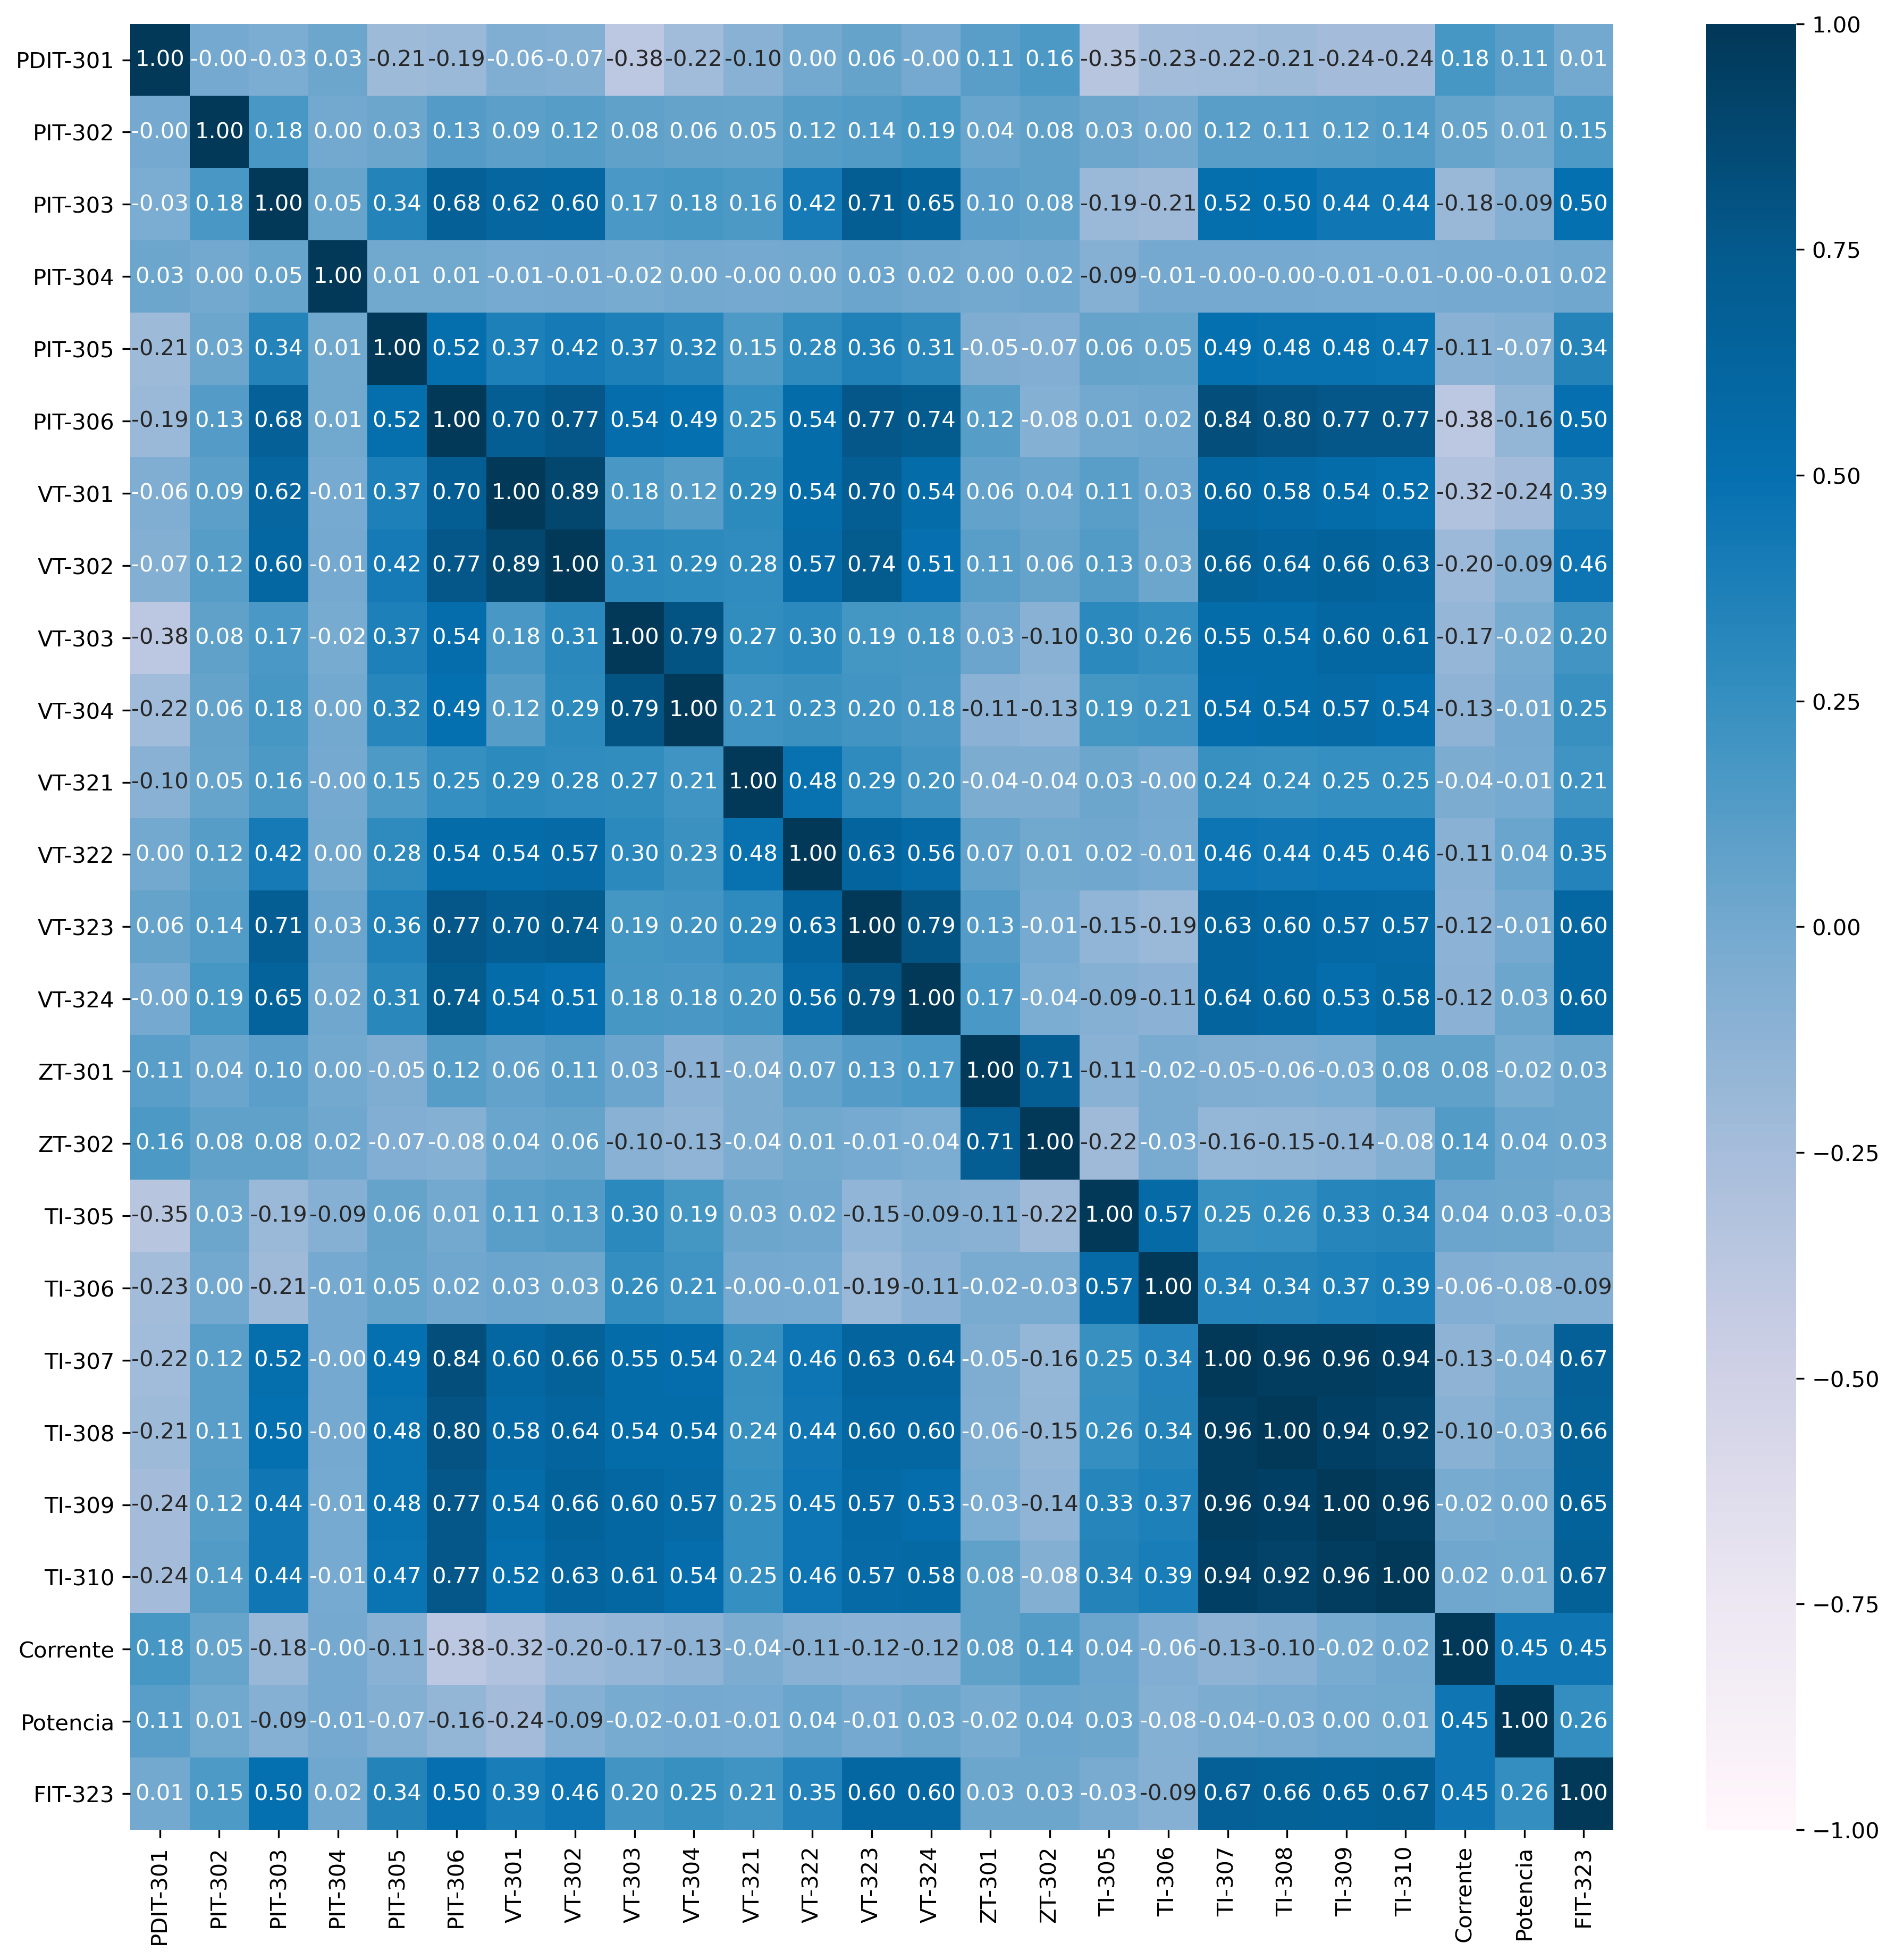

In [31]:
# Matriz de correlação

plt.figure(figsize=(15,15), dpi=300)
ax = sns.heatmap(data_corr, annot=True, cmap='PuBu', vmin=-1, vmax=1, fmt='.2f')
plt.show();

# # Opção 02 de plot - apenas metade da matriz de correlação (já que ela é espelhada)
# mask = np.zeros_like(data_corr)
# mask[np.triu_indices_from(mask)] = True
# with sns.axes_style("white"):
#     f, ax = plt.subplots(figsize=(17, 17))
#     ax = sns.heatmap(data_corr, mask=mask, annot=True, cmap='PuBu', vmin=-1, vmax=1, fmt='.2f')

ax.figure.savefig(saving_path + "/confusion_matrix_heatmap_pump.png")

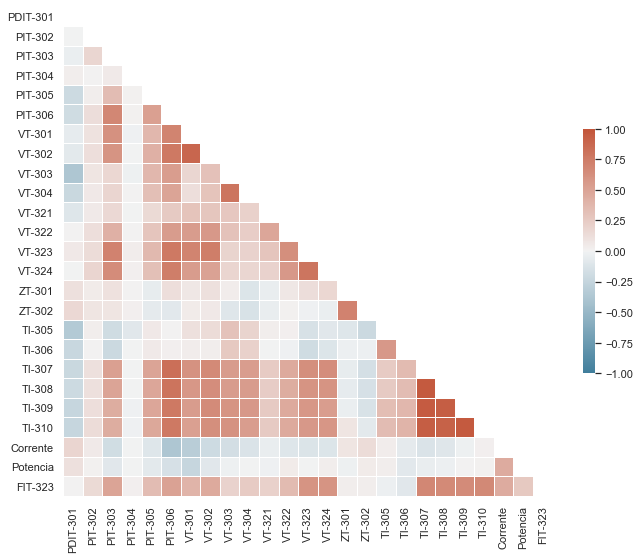

In [32]:
# Outra opção de visualização da matriz de correlação

from string import ascii_letters

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data_corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.figure.savefig(saving_path + "/new_confusion_matrix_heatmap_pump.png", bbox_inches='tight');

### Cenários - Dados completos

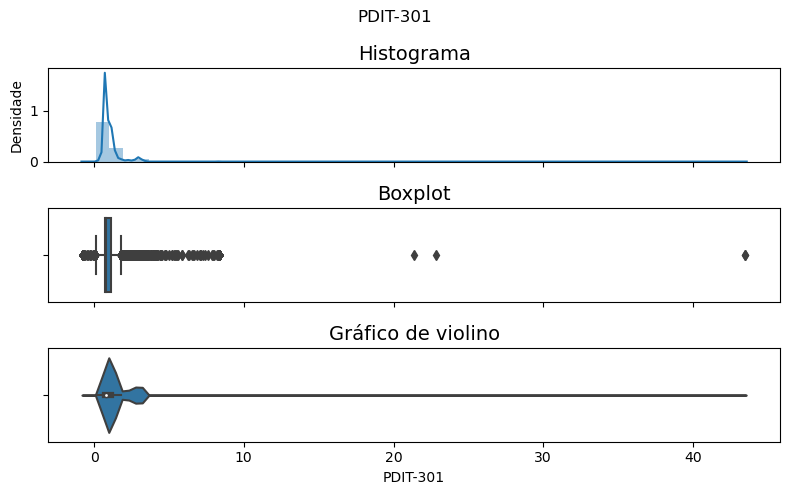

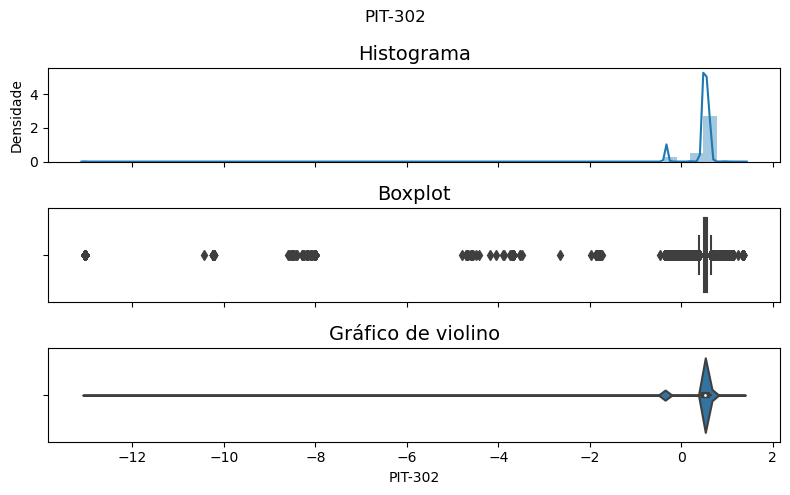

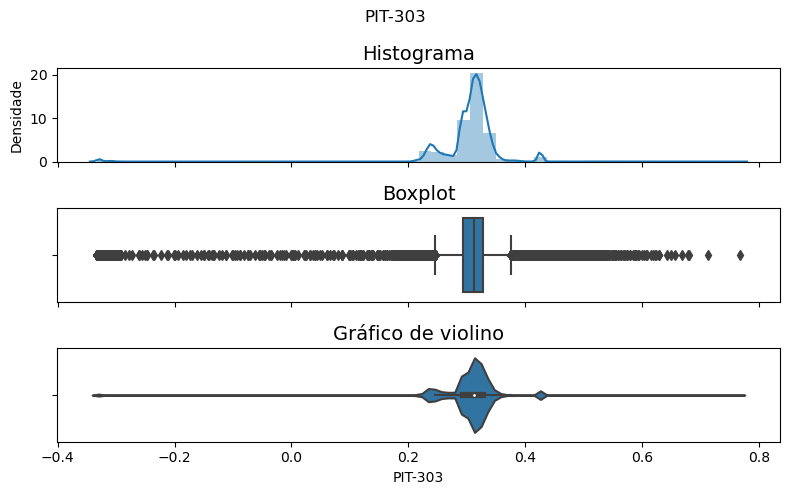

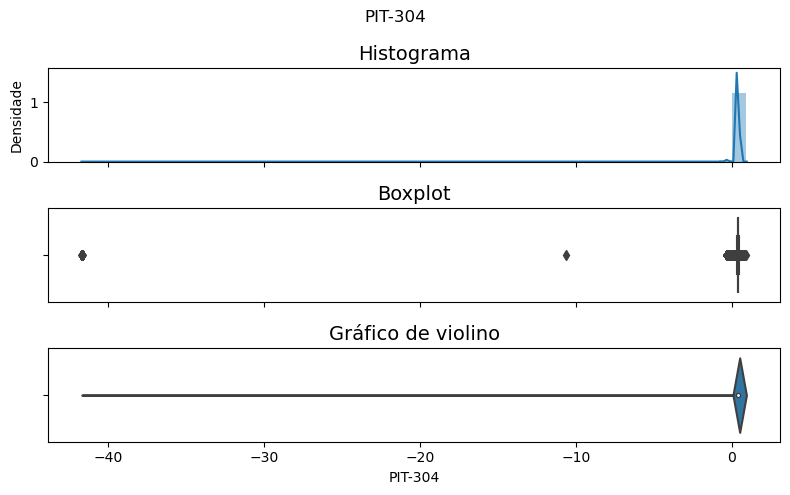

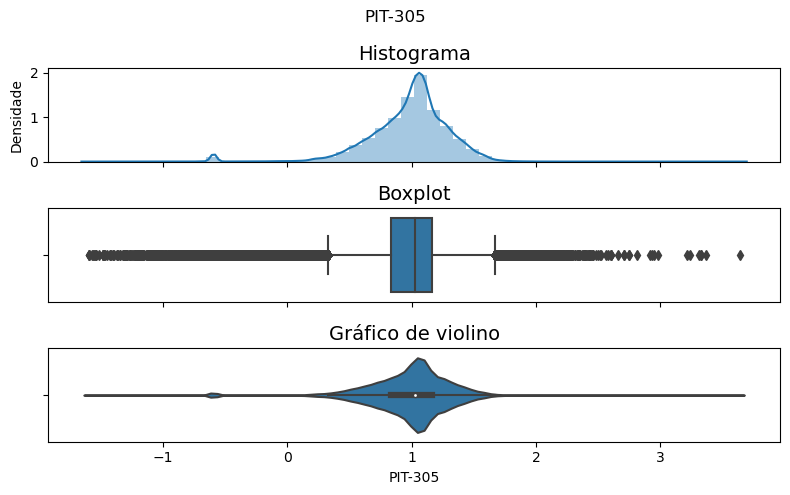

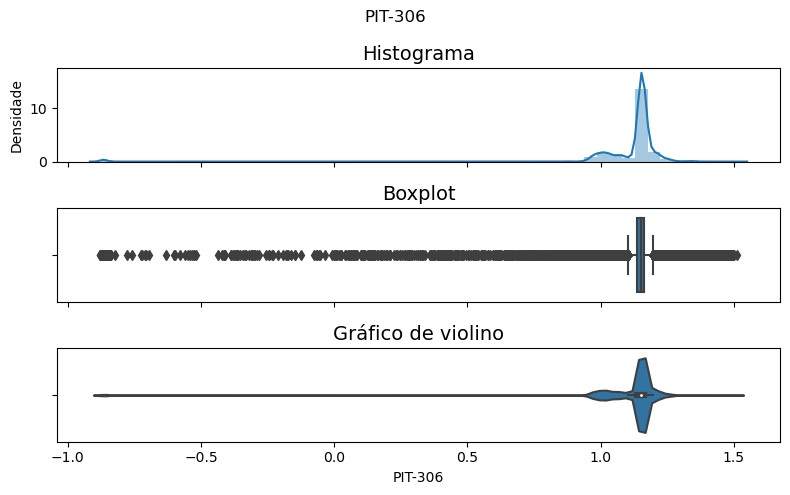

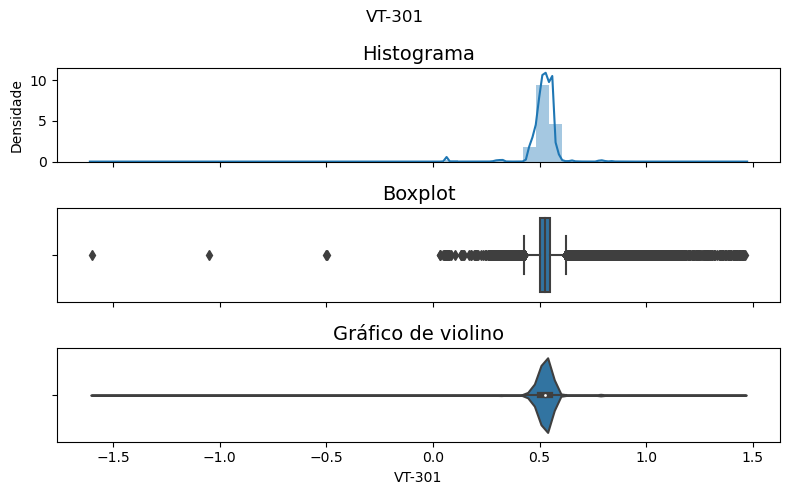

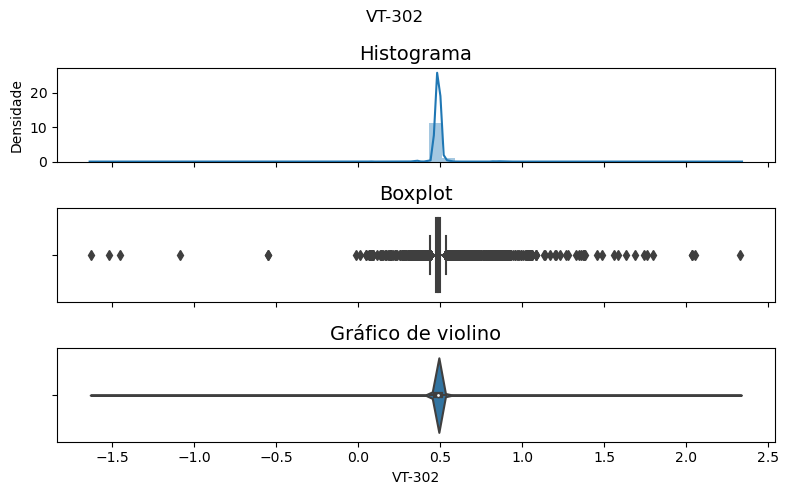

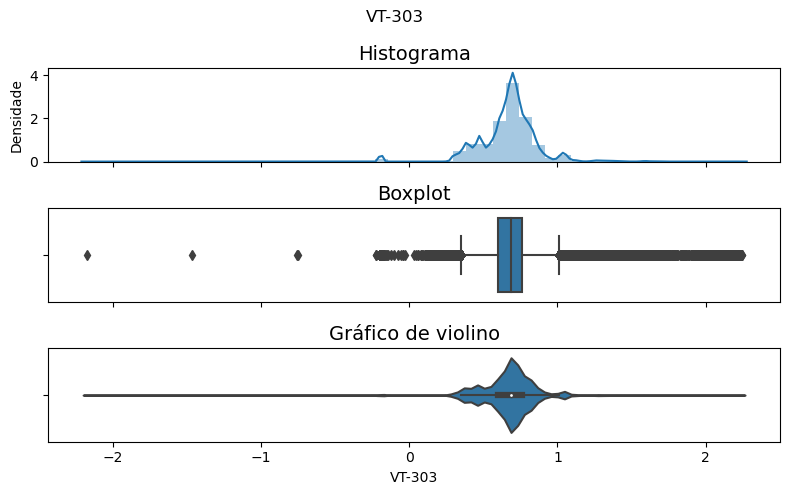

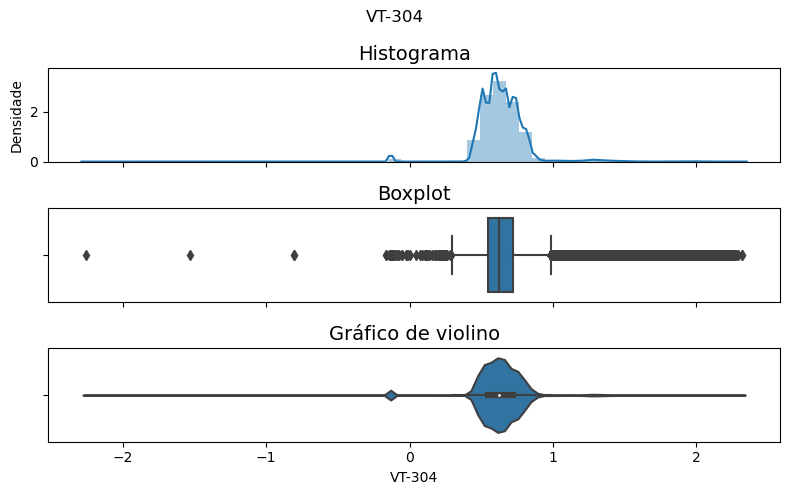

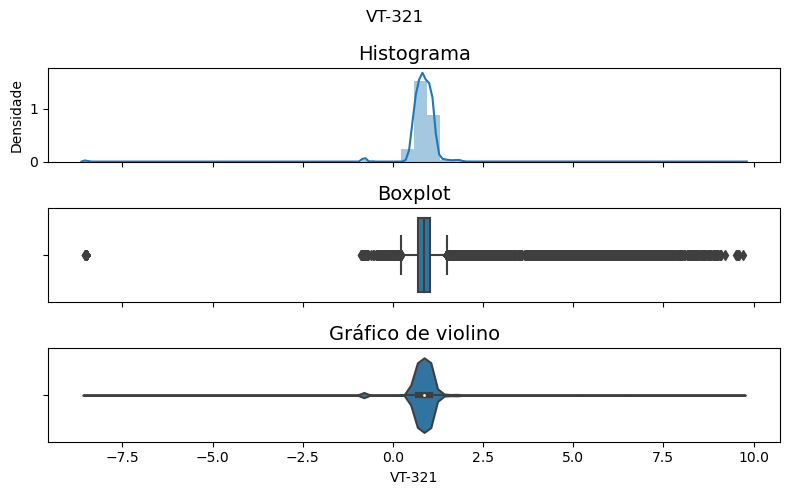

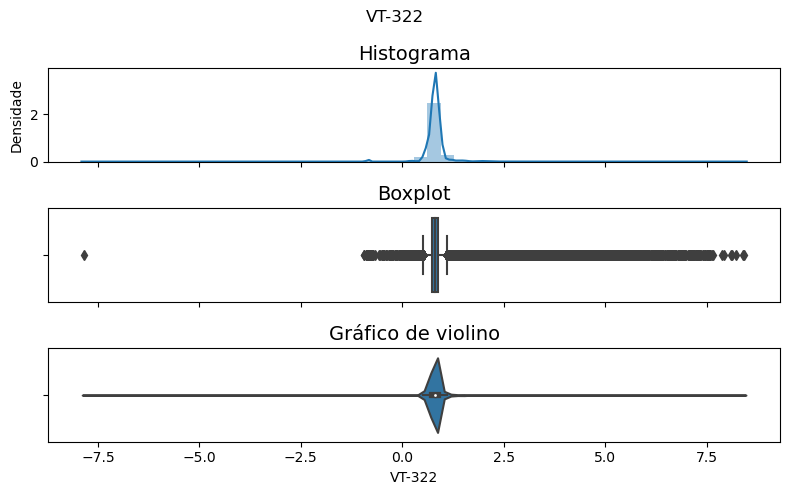

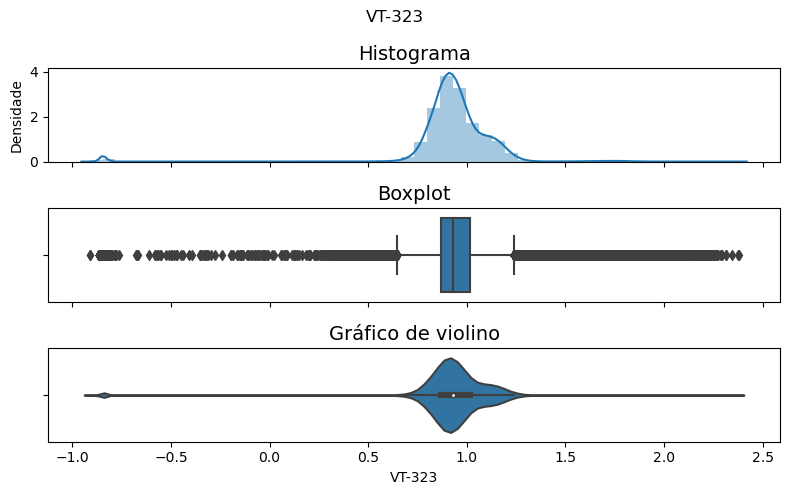

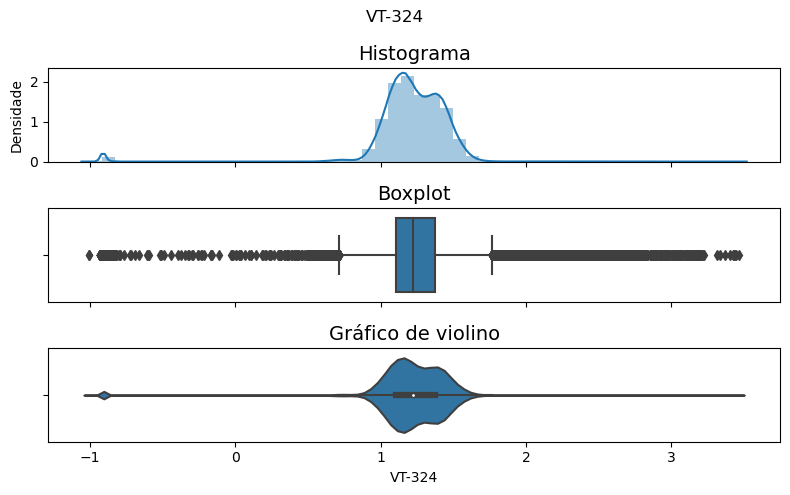

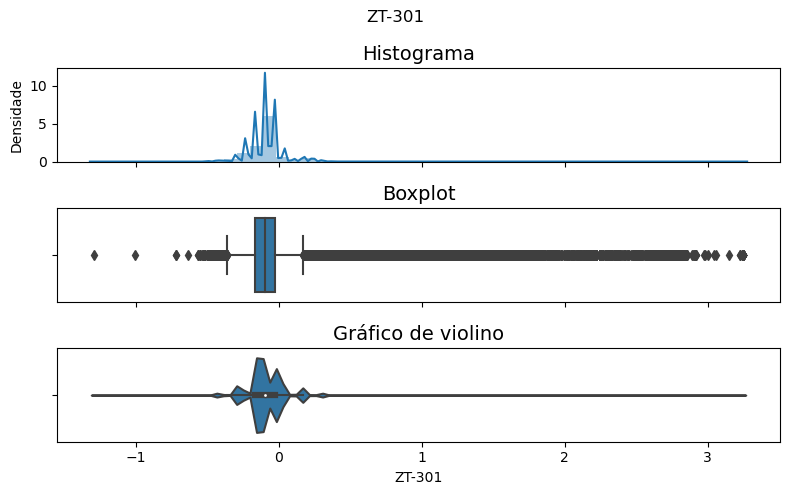

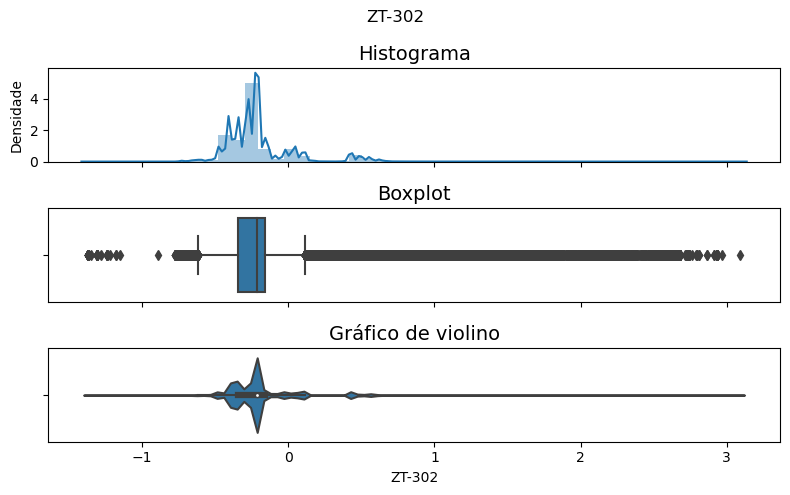

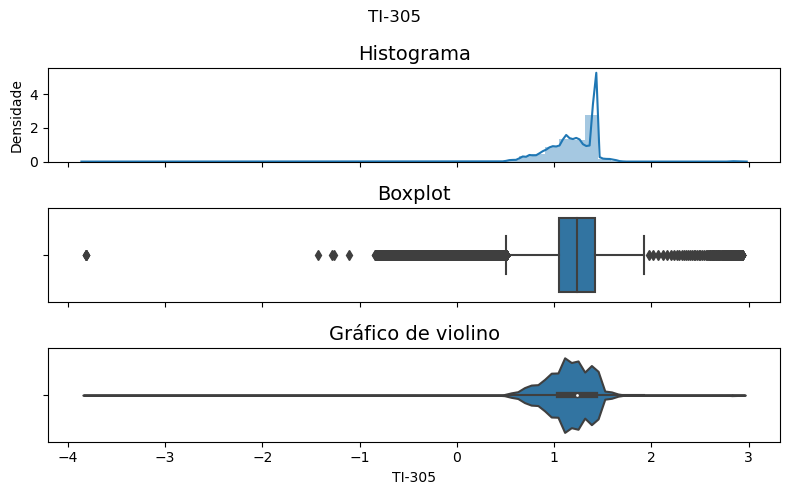

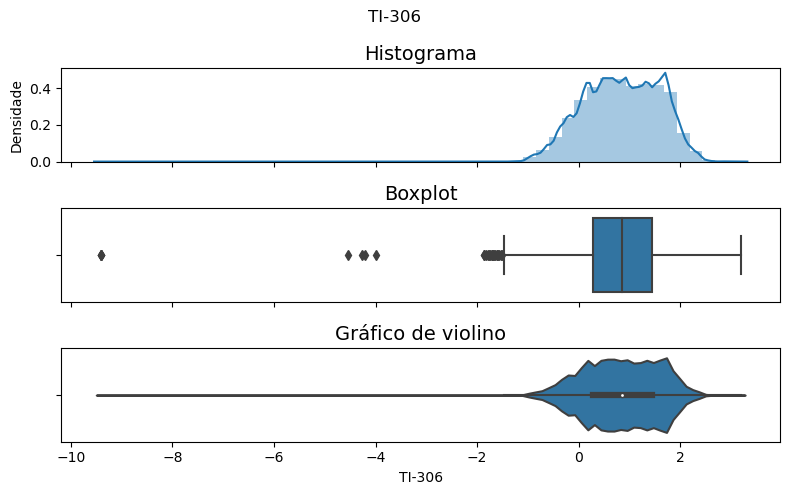

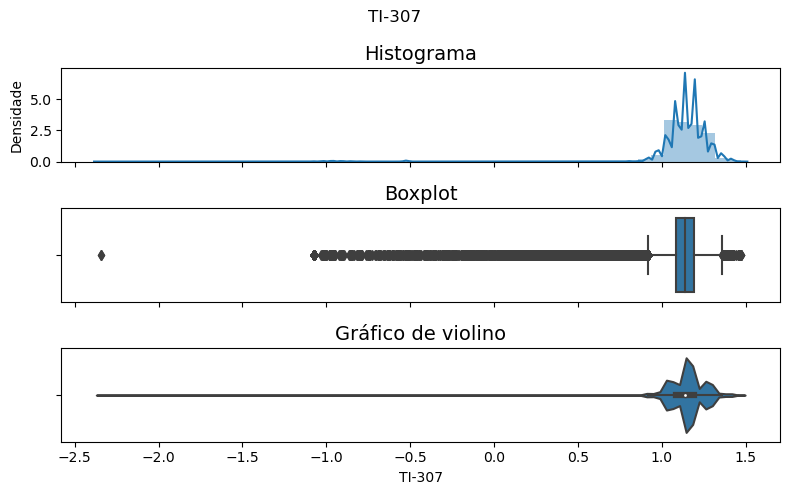

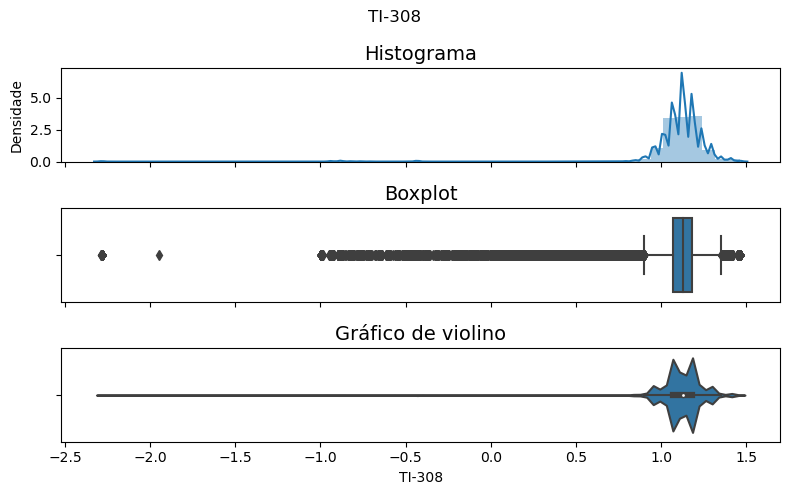

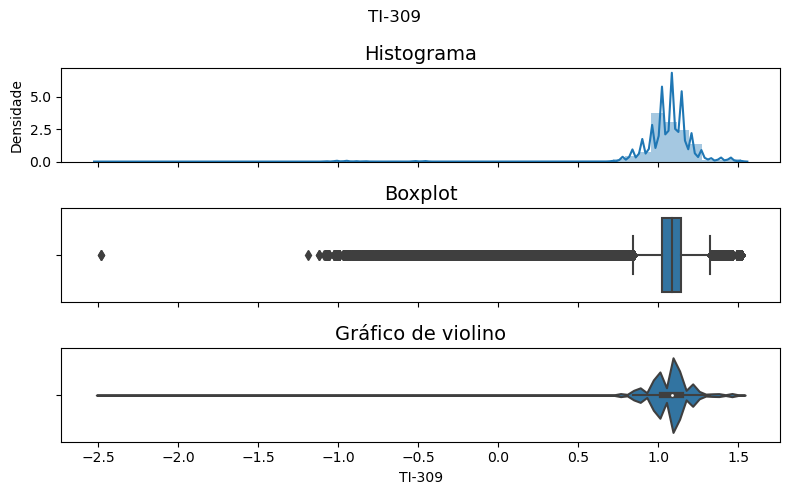

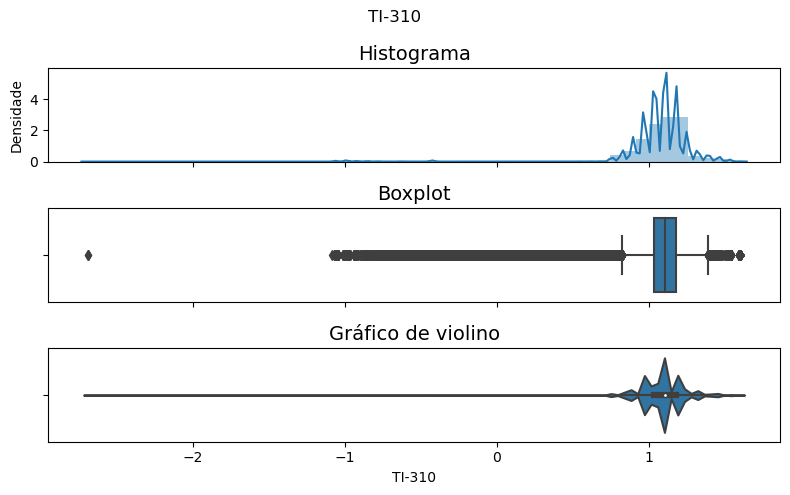

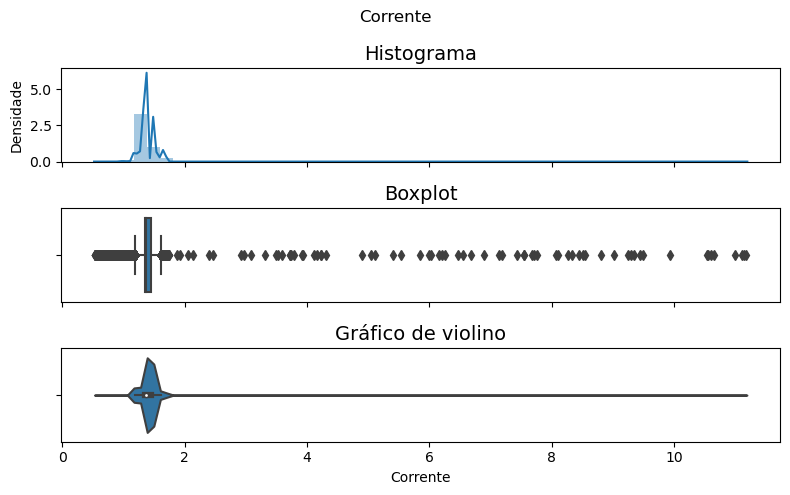

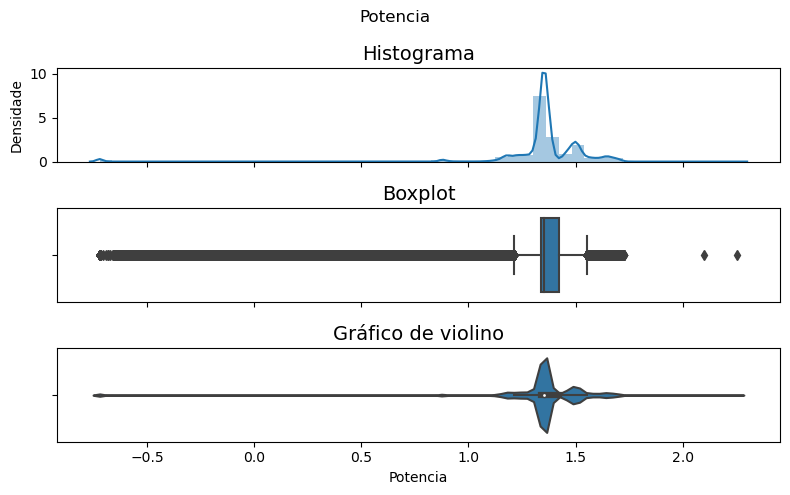

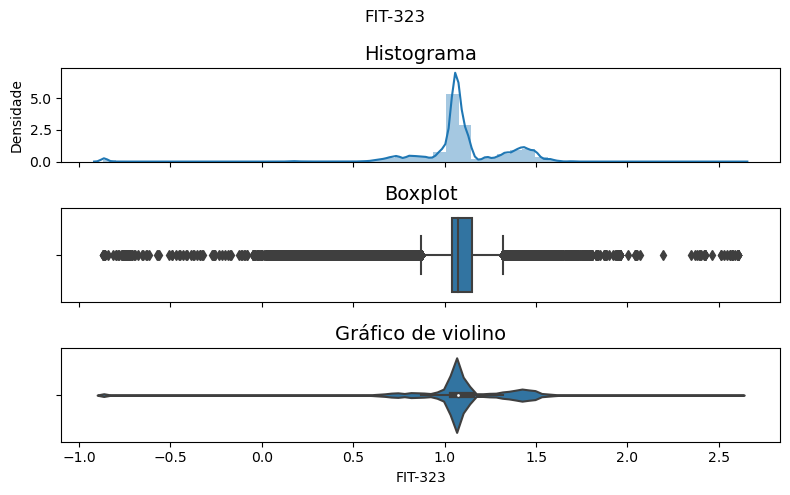

In [32]:
# Histograma / Boxplot / Gráfico de violino

data_to_plot = final_data.drop(['timestamp'], axis=1)

for col in data_to_plot.columns:
    plot_comparison(data_to_plot[col], col)


(1435326, 26)
Min. timestamp:  2011-01-03 10:31:00
Max. timestamp:  2018-12-24 10:03:00


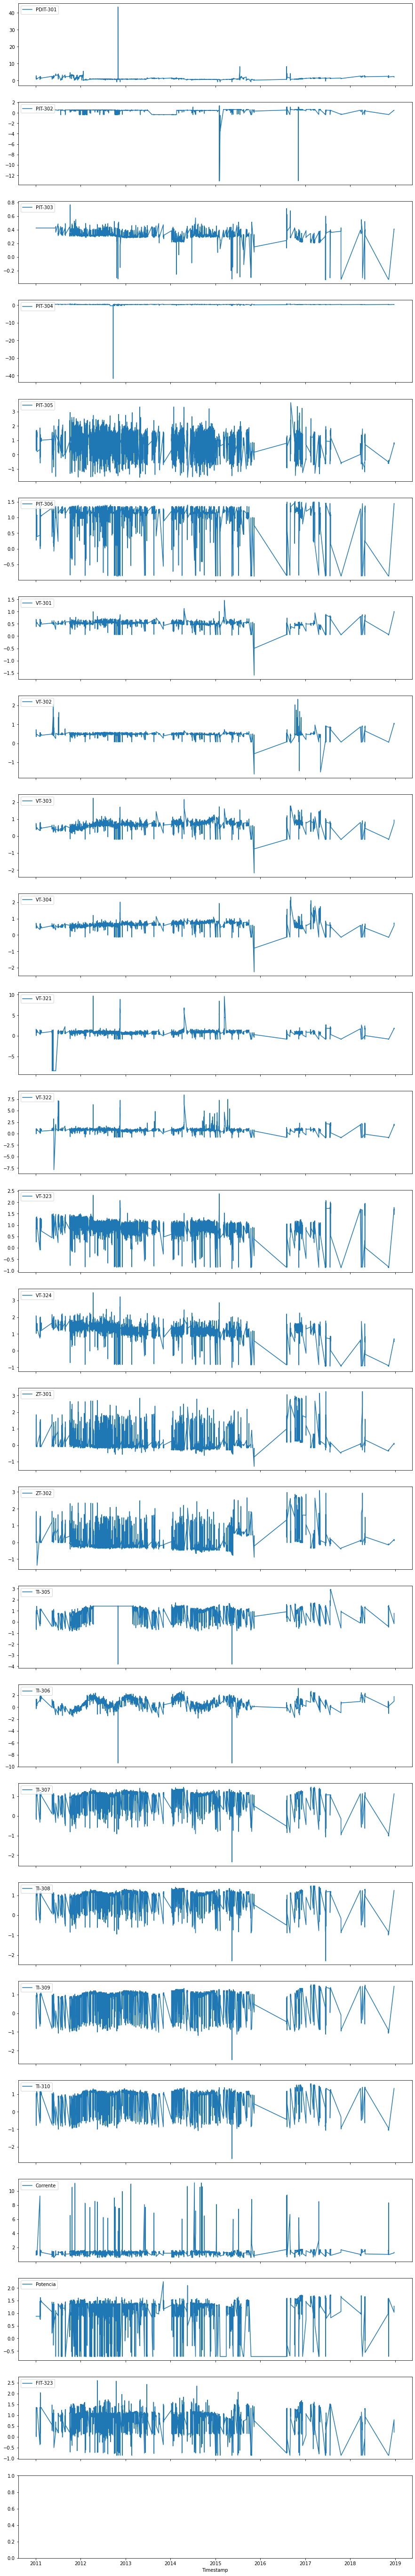

In [33]:
# Gráficos de linha das variáveis

fig, ax = plt.subplots(nrows=final_data.shape[1], ncols=1, sharex=True, figsize=(15,100))
columns = final_data.columns[:-1]

print()
print(final_data.shape)
print("Min. timestamp: ", final_data['timestamp'].min())
print("Max. timestamp: ", final_data['timestamp'].max())

for i in range (final_data.shape[1]-1):

    ax[i].plot(final_data['timestamp'], final_data[columns[i]], label=columns[i])
    ax[i].legend(loc='upper left')

plt.xlabel('Timestamp');

### Cenários - 1 semana de opreação


(10080, 26)
Min. timestamp:  2012-01-01 00:00:00
Max. timestamp:  2012-01-08 10:11:00


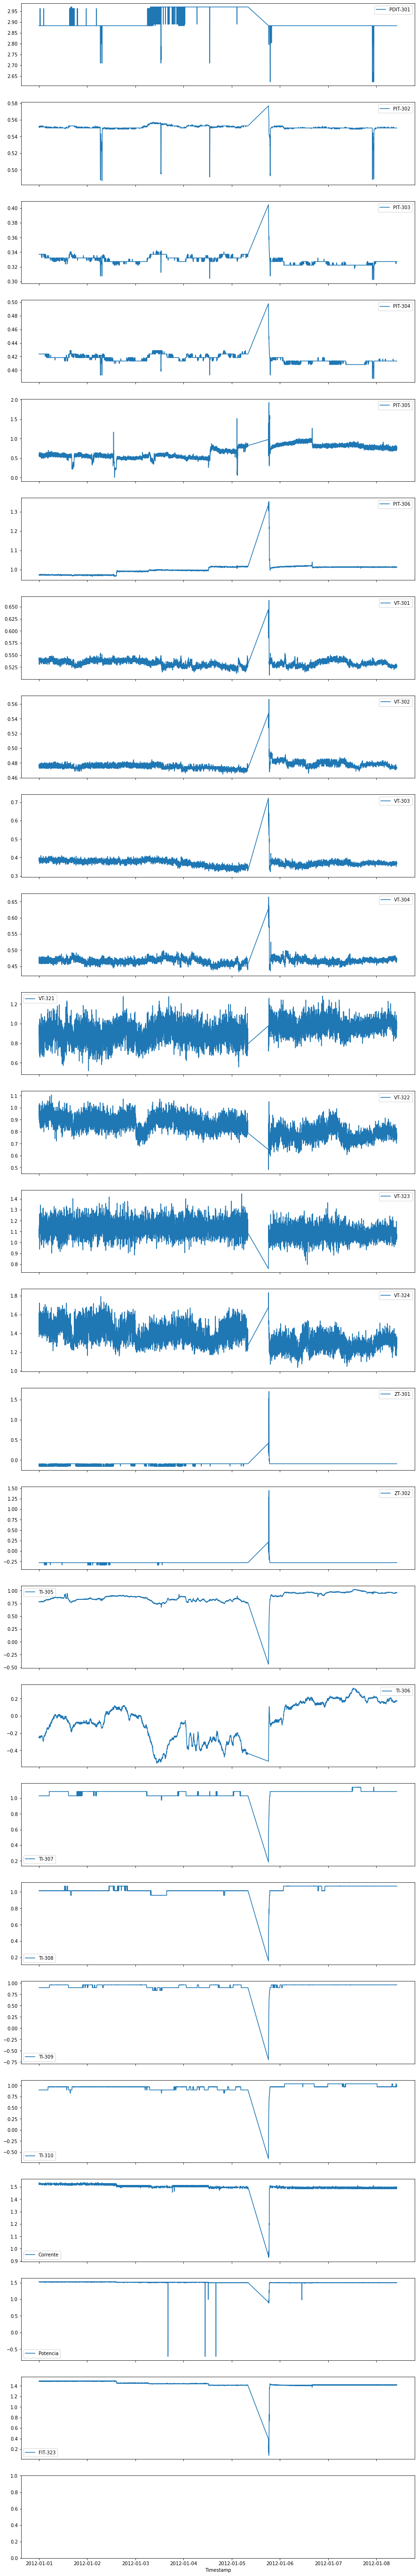

In [45]:
# Primeira semana de 2012
one_week_data = final_data[147749:157829].copy()

fig, ax = plt.subplots(nrows=one_week_data.shape[1], ncols=1, sharex=True, figsize=(15,100))
columns = one_week_data.columns

print()
print(one_week_data.shape)
print("Min. timestamp: ", one_week_data['timestamp'].min())
print("Max. timestamp: ", one_week_data['timestamp'].max())

i=0
for col in one_week_data.columns[:-1]:

    ax[i].plot(one_week_data['timestamp'], one_week_data[col], label=col) #one_week_data['timestamp'], 
    ax[i].legend(loc='best')
    i=i+1

plt.xlabel('Timestamp');

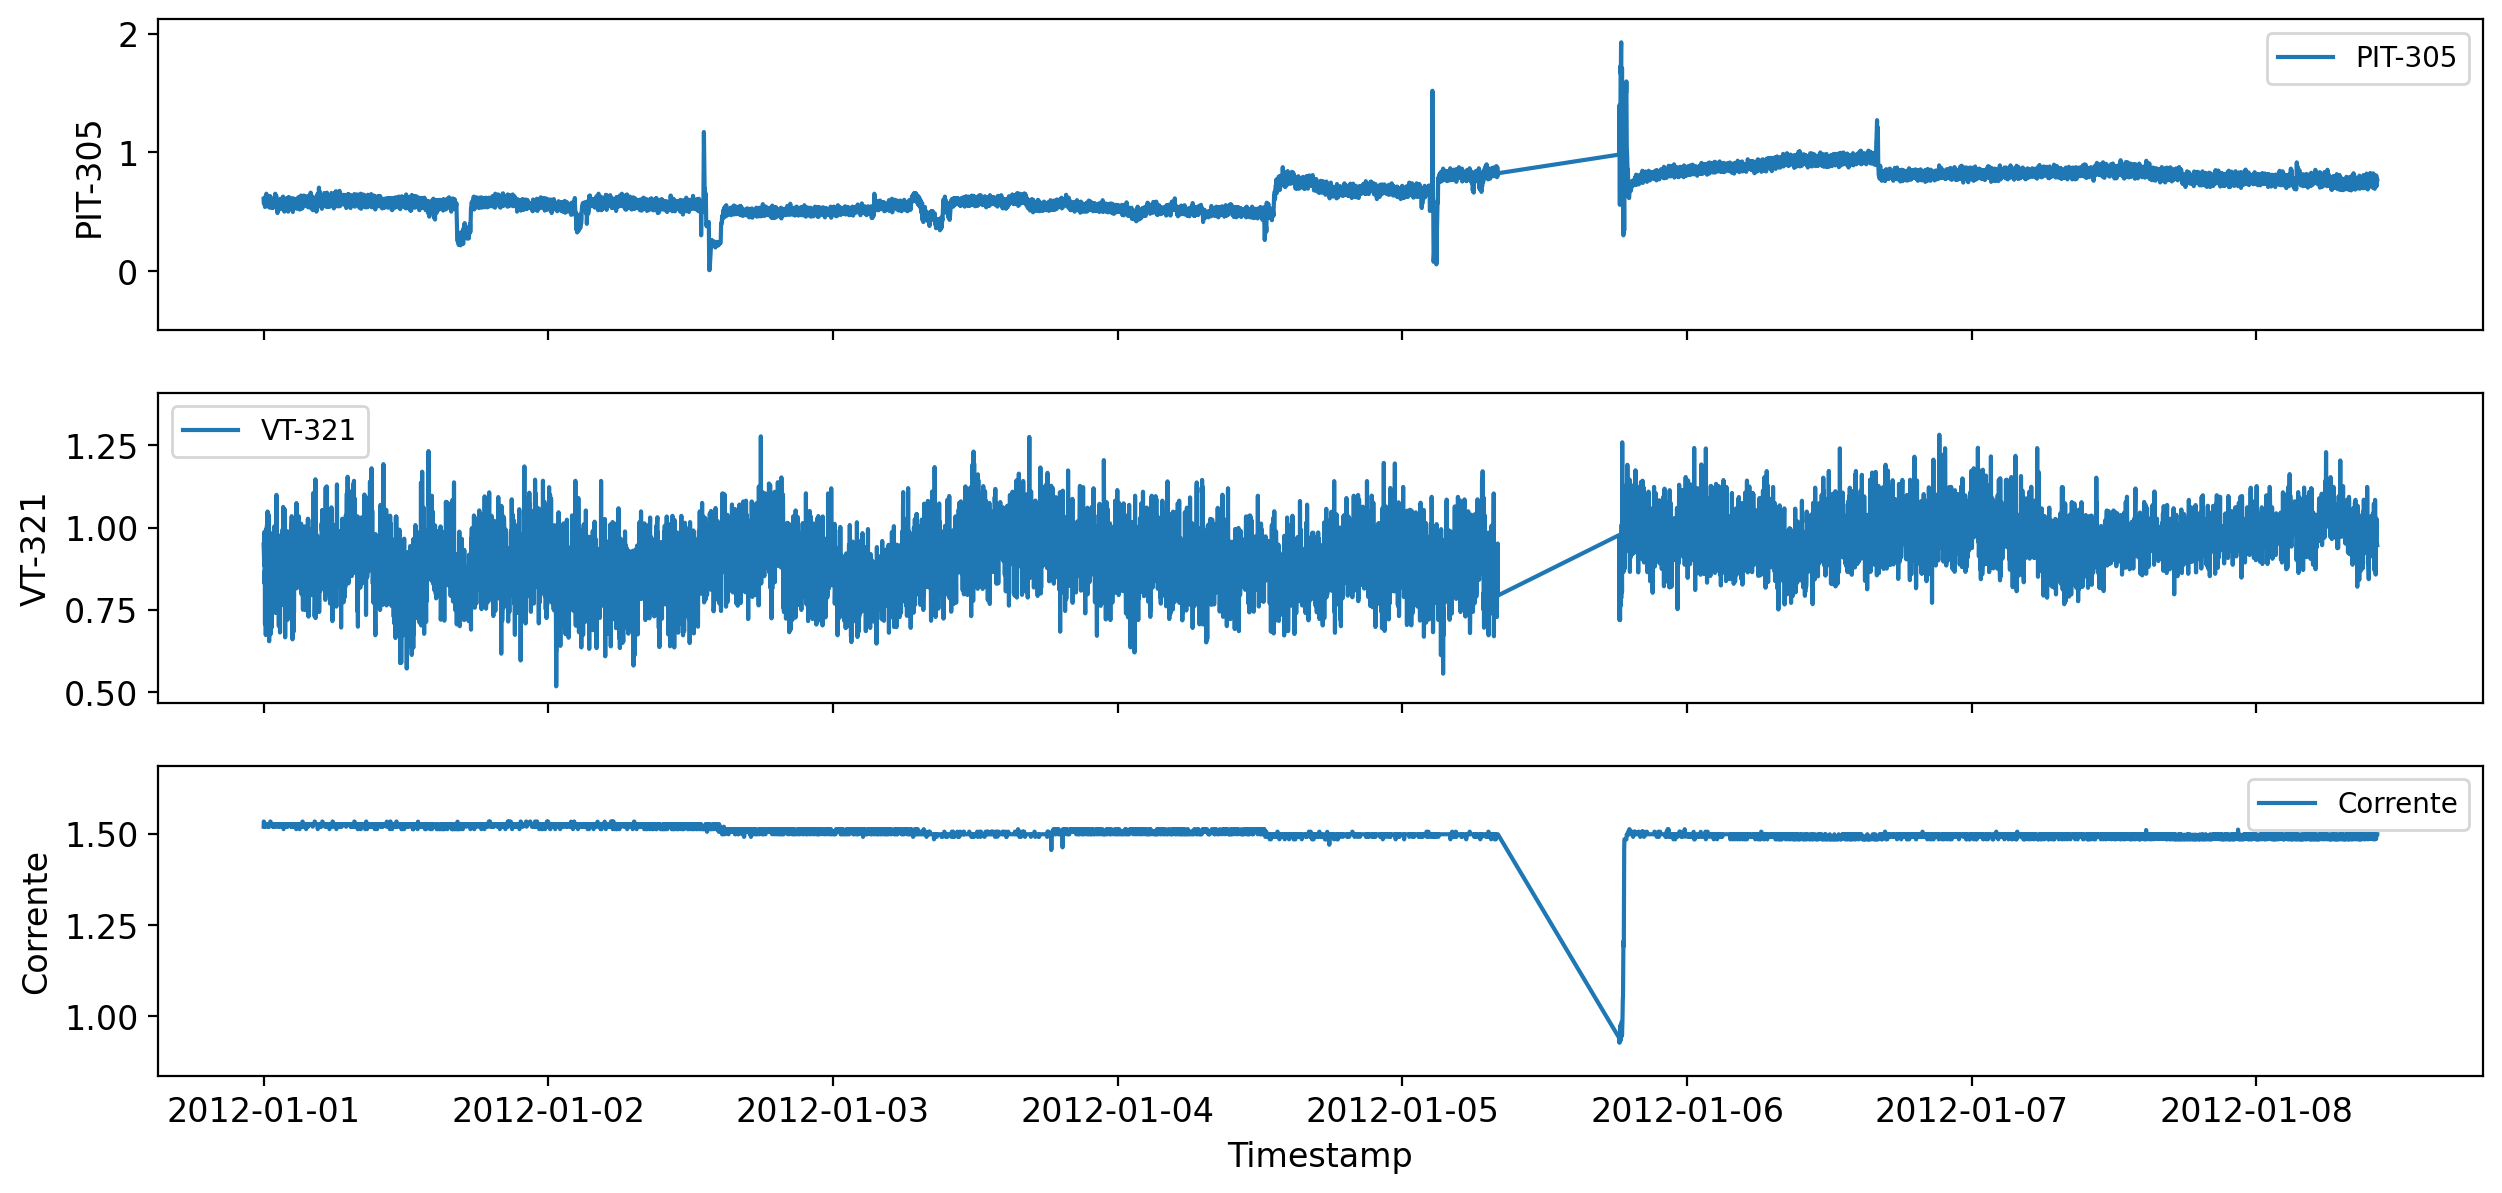

In [73]:
# Variáveis selecionadas

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15,7), dpi=200)

col='PIT-305'
ax[0].plot(one_week_data['timestamp'], one_week_data[col], label=col)
ax[0].set_ylim([-0.5, one_week_data[col].max()+one_week_data[col].max()*0.1])
ax[0].set_ylabel(col, fontsize=12)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].legend(loc='best')
ax[0].plot()

col='VT-321'
ax[1].plot(one_week_data['timestamp'], one_week_data[col], label=col)
ax[1].set_ylim([one_week_data[col].min()-one_week_data[col].min()*0.1,one_week_data[col].max()+one_week_data[col].max()*0.1])
ax[1].set_ylabel(col, fontsize=12)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].legend(loc='best')
ax[1].plot();

col='Corrente'
ax[2].plot(one_week_data['timestamp'], one_week_data[col], label=col)
ax[2].set_ylim([one_week_data[col].min()-one_week_data[col].min()*0.1,one_week_data[col].max()+one_week_data[col].max()*0.1])
ax[2].set_ylabel(col, fontsize=12)
ax[2].tick_params(axis='both', labelsize=12)
ax[2].legend(loc='best')
ax[2].plot();

plt.xlabel('Timestamp', fontsize=12);

fig.savefig(saving_path + '/figura31.png', format='png')

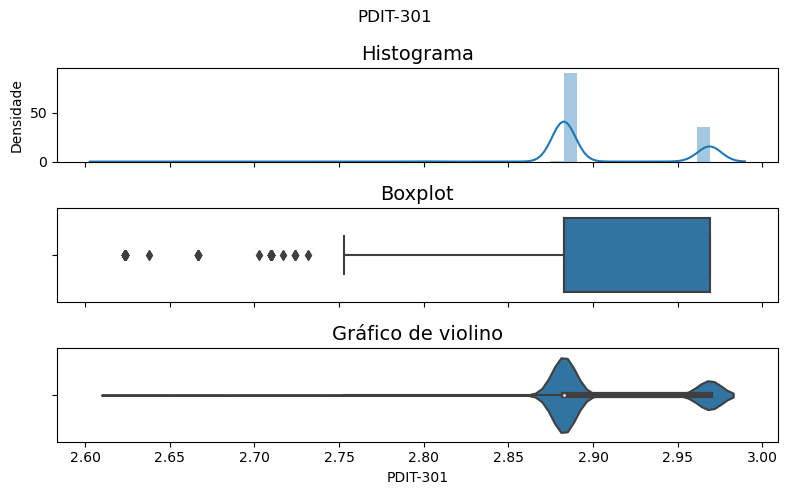

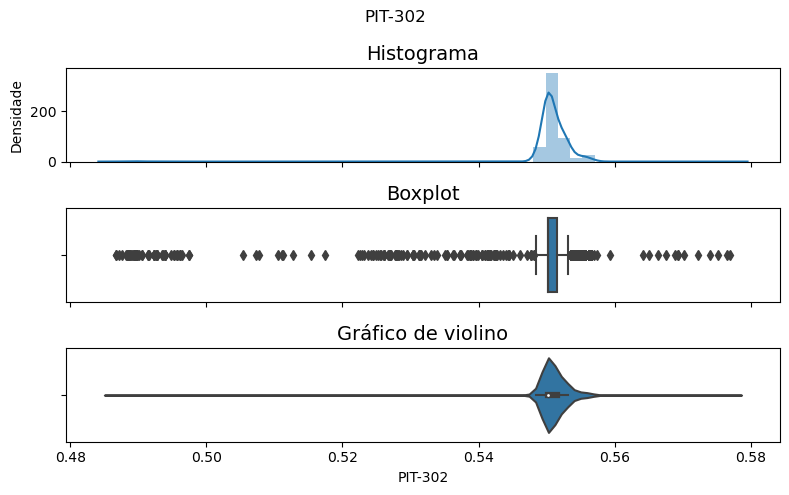

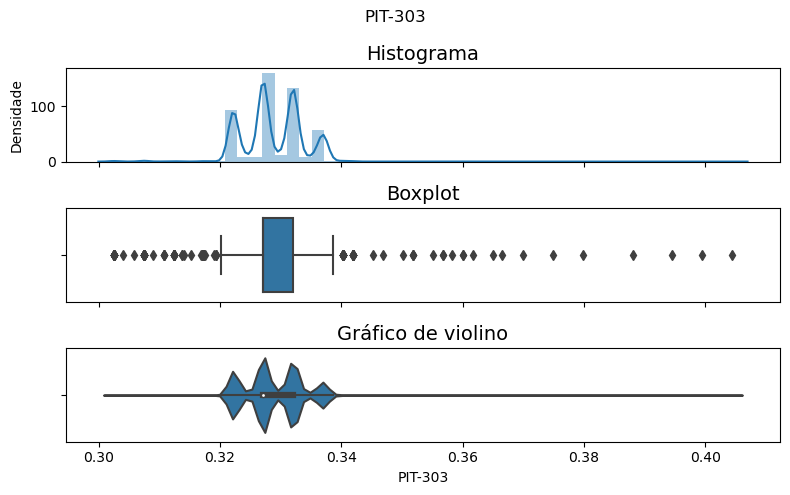

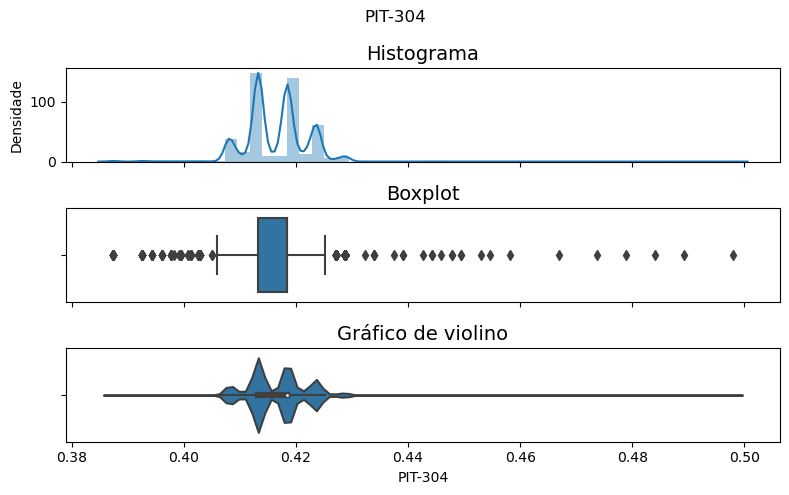

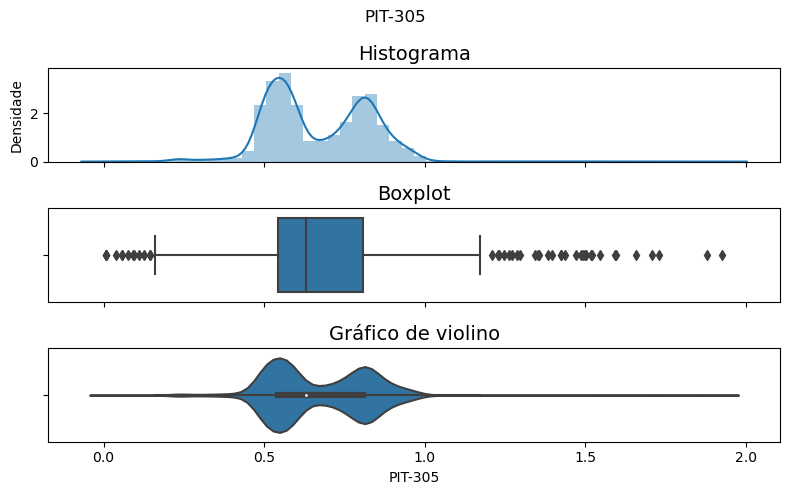

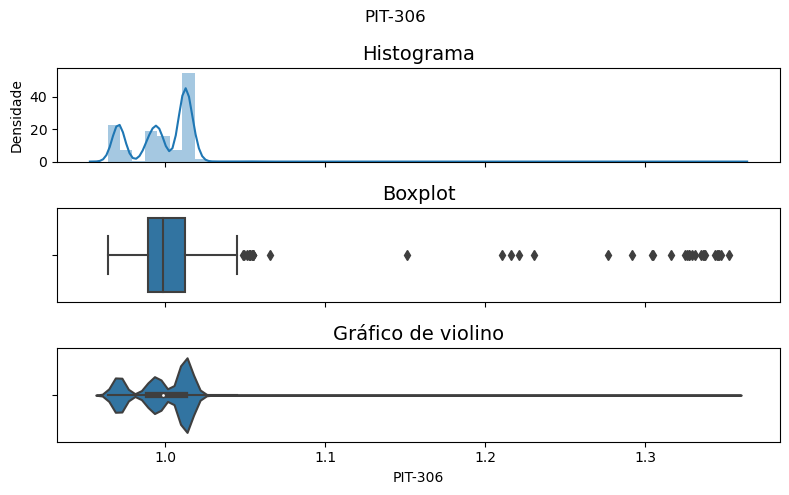

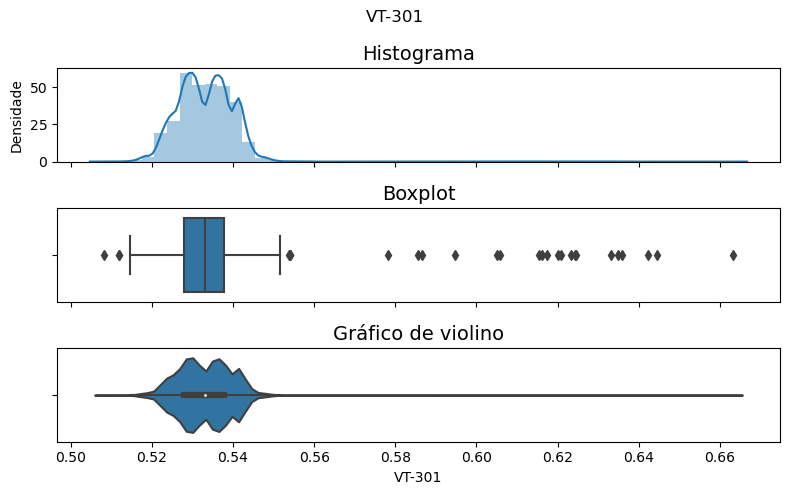

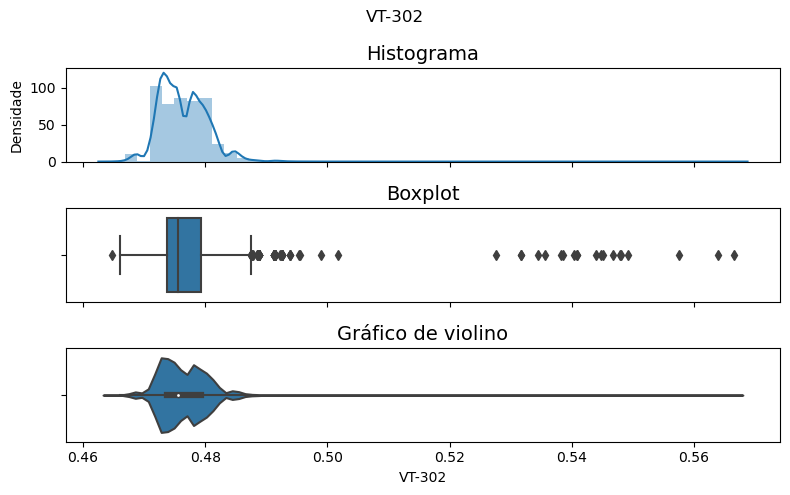

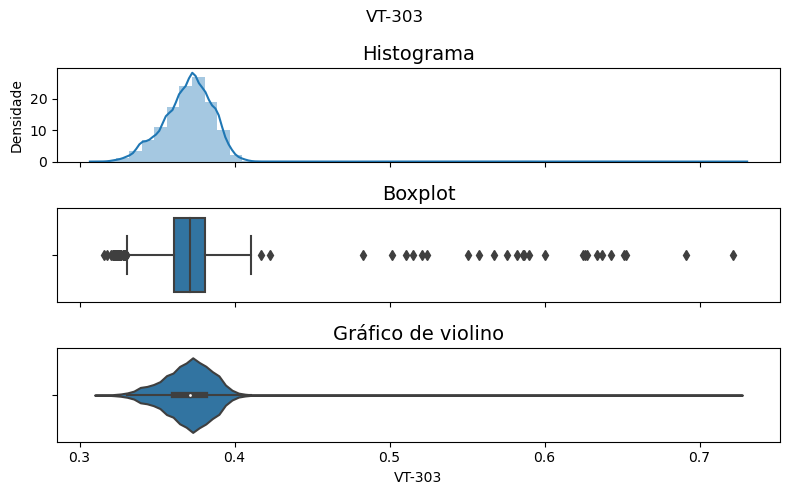

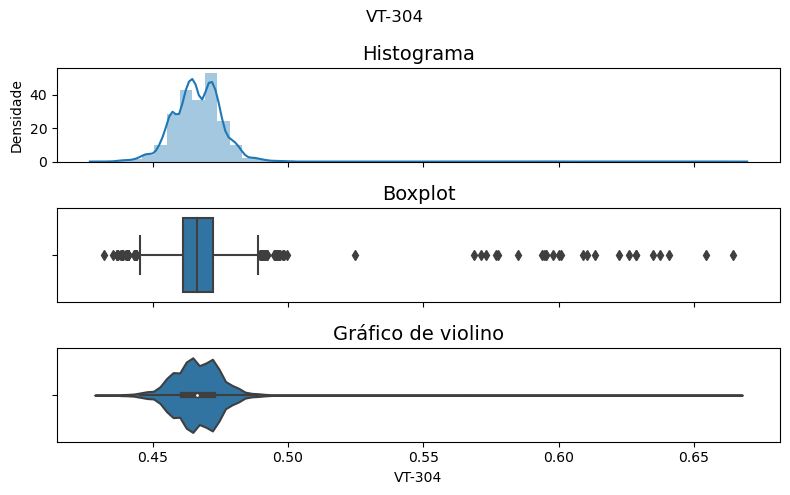

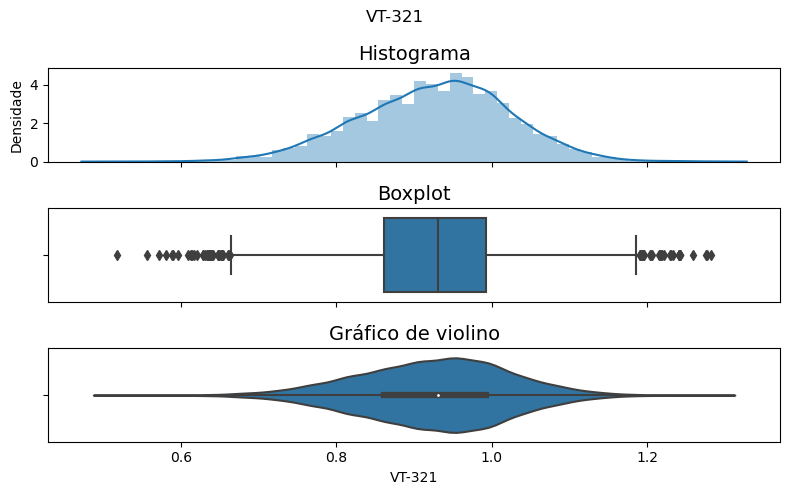

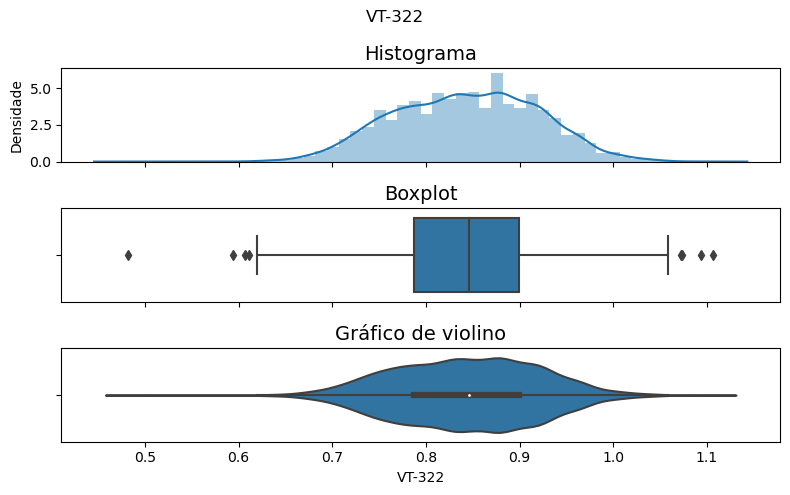

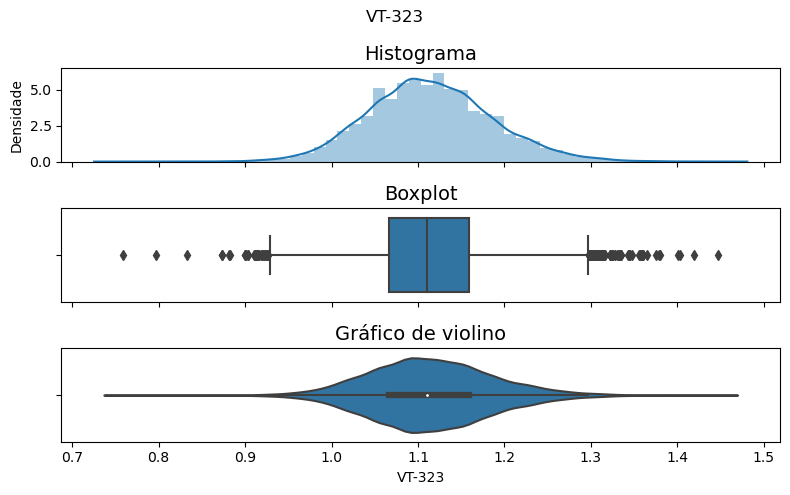

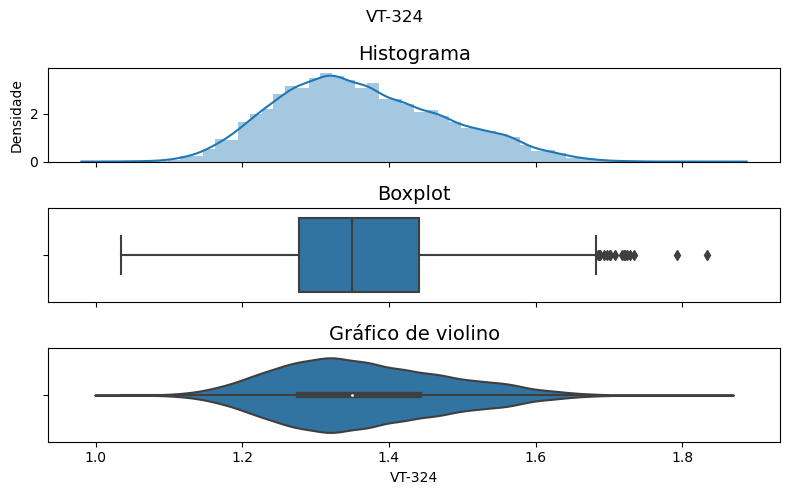

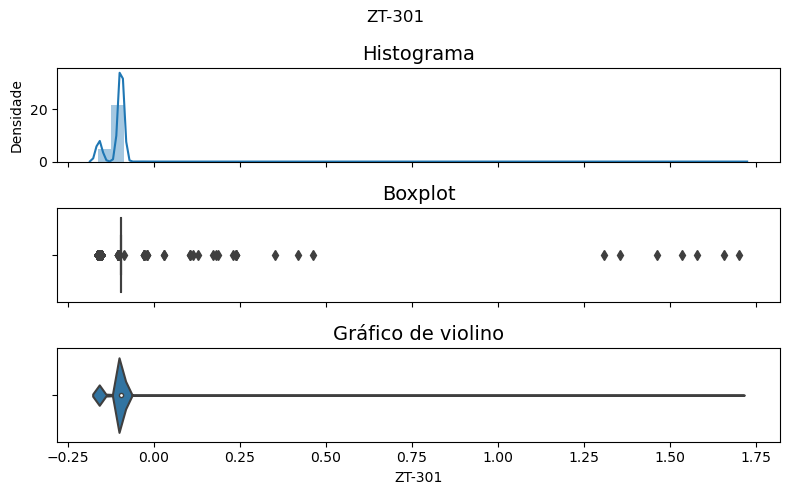

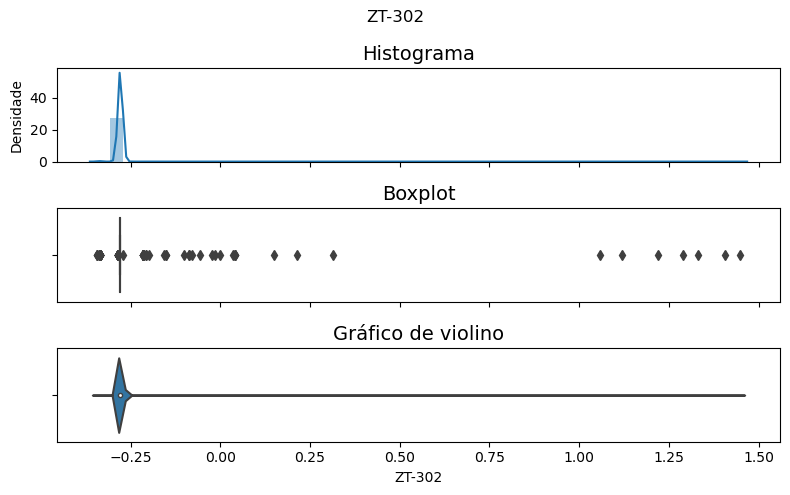

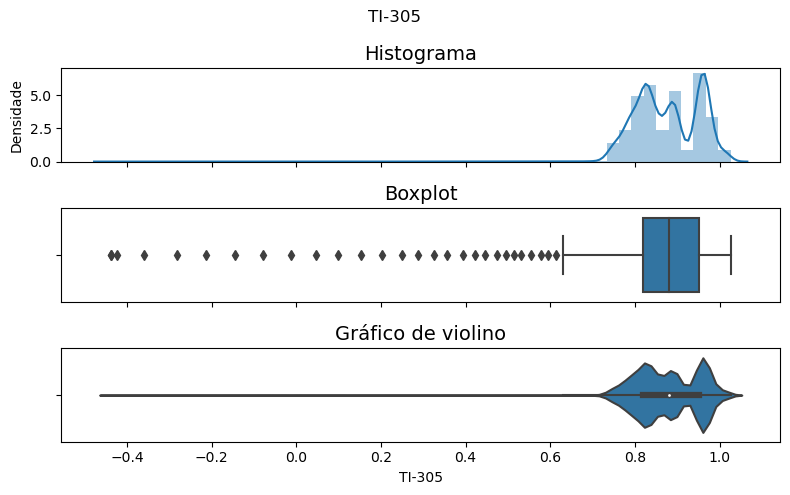

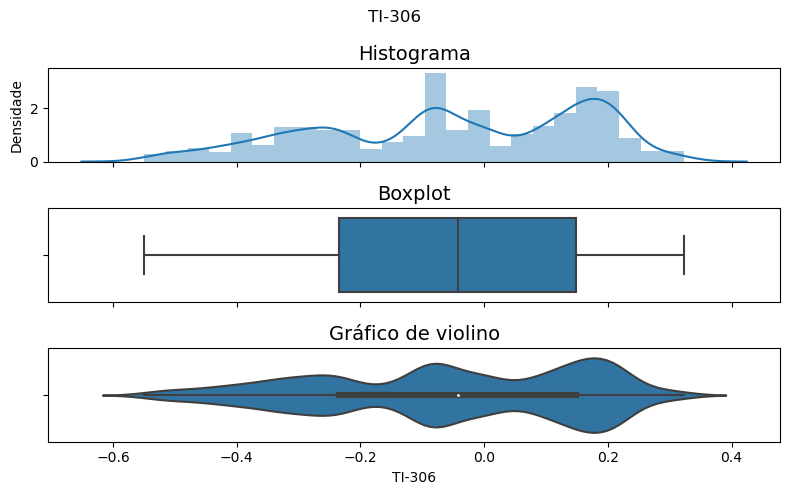

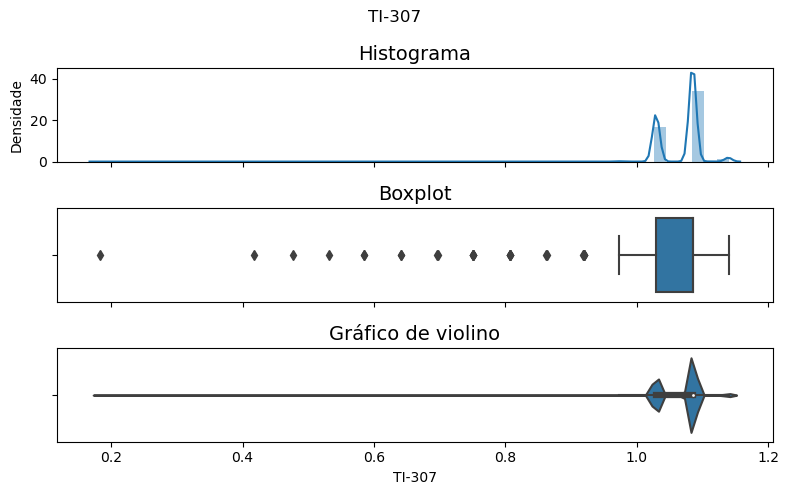

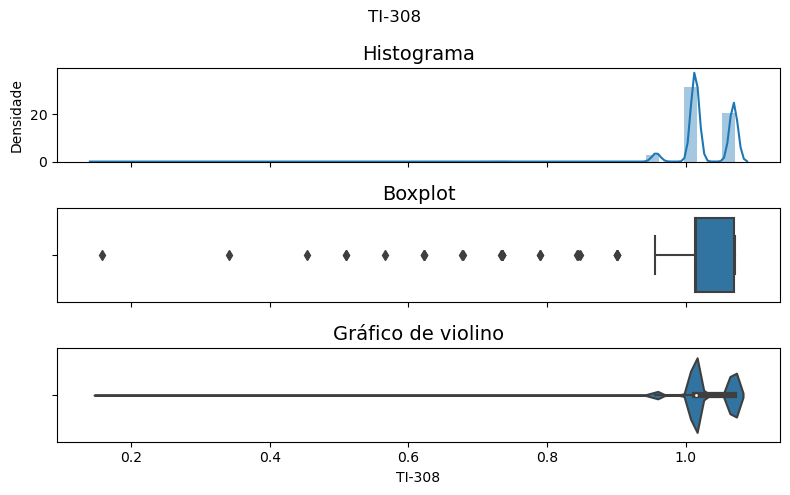

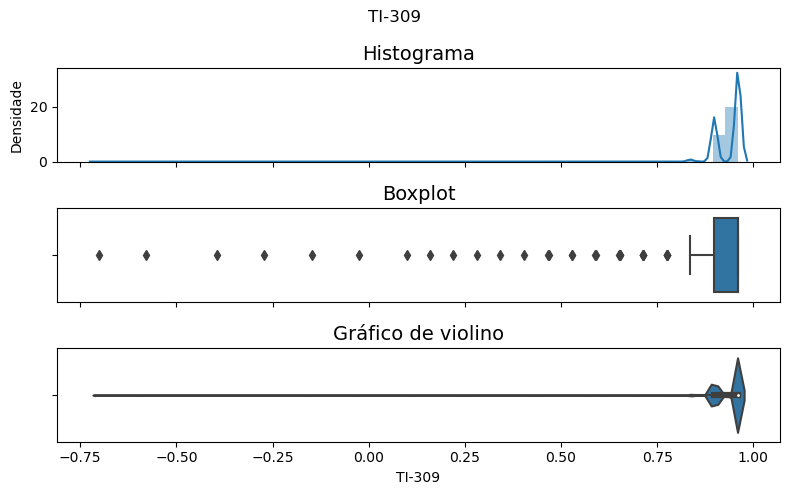

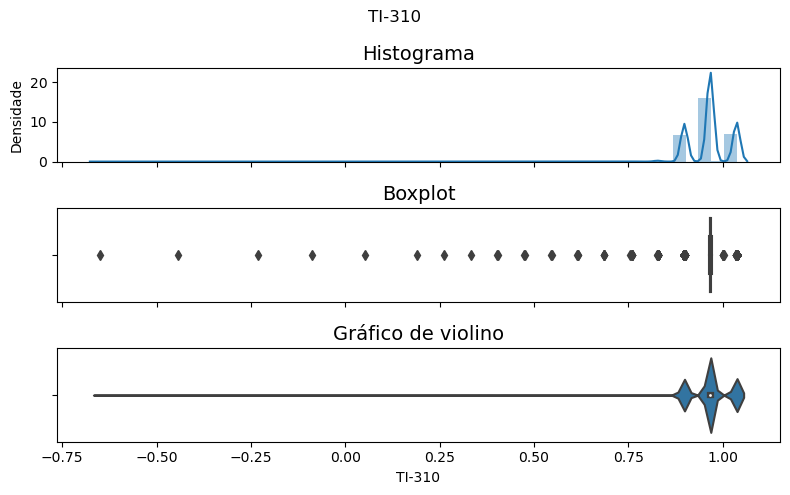

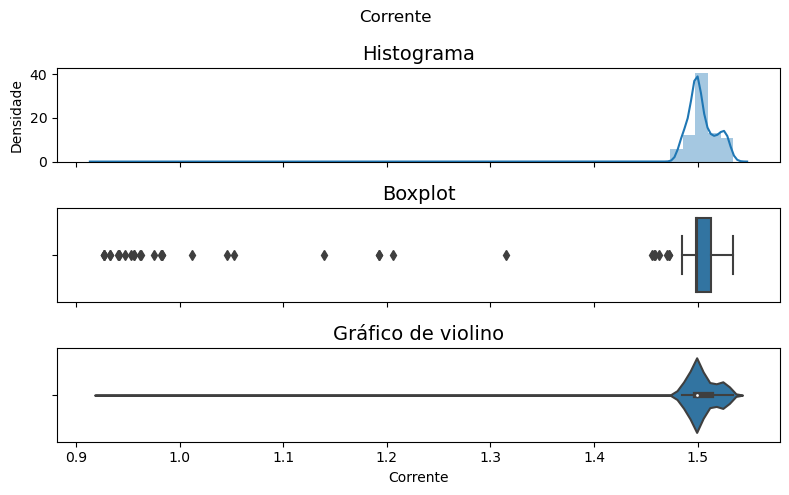

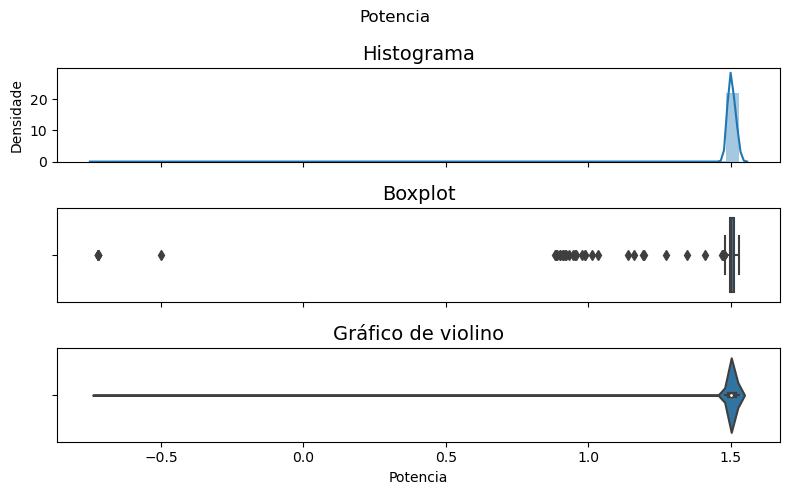

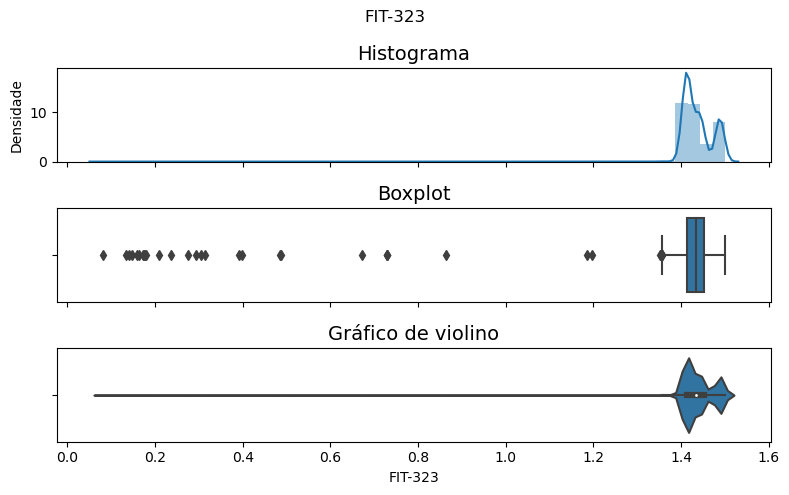

In [41]:
# Histograma / Boxplot / Gráfico de violino

for col in one_week_data.columns[:-1]:
    plot_comparison(one_week_data[col], col)

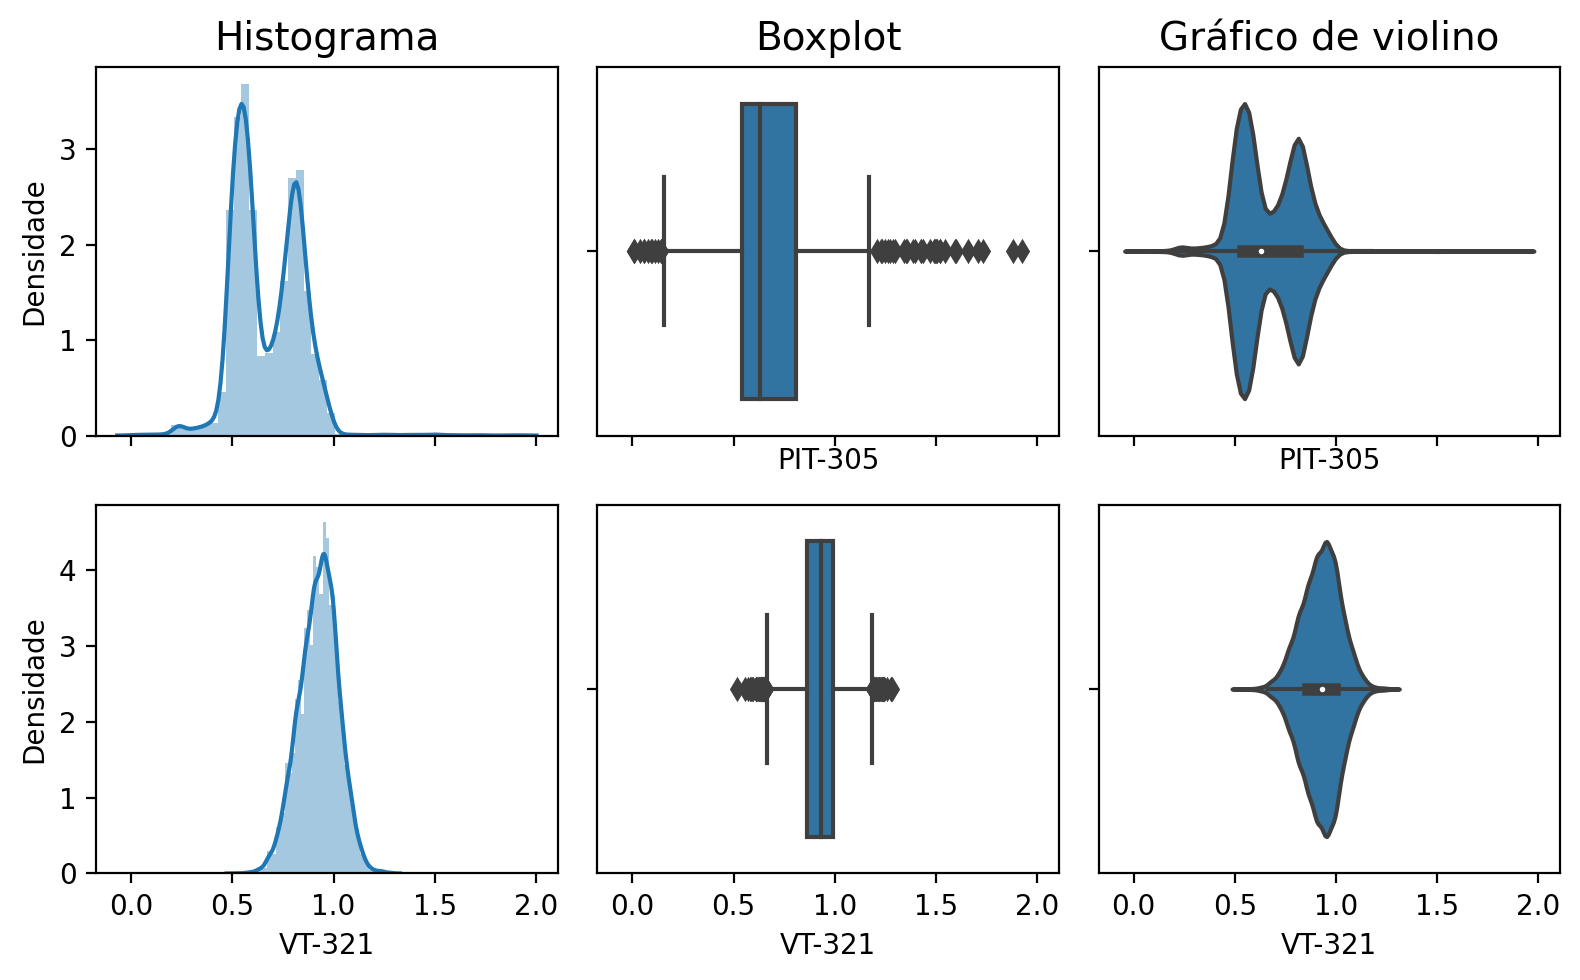

In [89]:
# Variáveis selecionadas

fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(8,5), dpi=200)

col='PIT-305'
sns.distplot(one_week_data[col], ax=ax[0,0])
ax[0,0].set_title('Histograma', fontsize=14)
ax[0,0].set(ylabel='Densidade')
ax[0,0].set(xlabel=col)

col='PIT-305'
sns.boxplot(one_week_data[col], ax=ax[0,1])
ax[0,1].set_title('Boxplot', fontsize=14)
ax[0,1].set(xlabel=col)

col='PIT-305'
sns.violinplot(one_week_data[col], ax=ax[0,2])
ax[0,2].set_title('Gráfico de violino', fontsize=14)
ax[0,2].set(xlabel=col)

col='VT-321'
sns.distplot(one_week_data[col], ax=ax[1,0])
ax[1,0].set(ylabel='Densidade')
ax[1,0].set(xlabel=col)

col='VT-321'
sns.boxplot(one_week_data[col], ax=ax[1,1])
ax[1,1].set(xlabel=col)

col='VT-321'
sns.violinplot(one_week_data[col], ax=ax[1,2])
ax[1,2].set(xlabel=col)

fig.savefig(saving_path + '/figura32.png', format='png')

fig.tight_layout()

In [87]:
# Skewness e kurtosis para 1 semana de operação

sk_kr = pd.DataFrame(one_week_data.kurt(), columns=['kurtosis'])
sk_kr['skewness'] = one_week_data.skew()
sk_kr

kurtosis   skewness
PDIT-301     4.773606  -0.372380
PIT-302     88.703635  -8.704896
PIT-303     14.379958   0.854561
PIT-304     14.525831   0.843938
PIT-305      1.488239   0.371703
PIT-306     84.973494   5.993908
VT-301      46.130891   3.525270
VT-302      83.502081   5.965650
VT-303      63.832020   4.460492
VT-304      77.777408   5.609797
VT-321       0.042652  -0.166499
VT-322      -0.454941  -0.053487
VT-323       0.304673   0.210788
VT-324      -0.342889   0.363476
ZT-301     722.501000  22.662563
ZT-302    1203.947135  33.498096
TI-305      37.560895  -2.912569
TI-306      -0.950929  -0.347300
TI-307      84.514401  -5.039722
TI-308      62.691292  -3.993774
TI-309     352.964053 -13.869818
TI-310     129.843450  -6.187683
Corrente   276.383629 -14.776708
Potencia  1027.494743 -29.779552
FIT-323    263.996015 -14.038216